In [1]:
#thats for API propose
import requests

def get(path, params=None):
    # make HTTP GET request to path
    headers = {"api-key":"83fb2a511946e50d7d8eb5c334bbc58c"}
    r = requests.get(path, params=params, headers=headers)

    # raise exception if response code is not HTTP SUCCESS (200)
    r.raise_for_status()

    if r.headers['content-type'] == 'application/json':
        return r.json() # parse json responses automatically

    if 'content-disposition' in r.headers:
        filename = r.headers['content-disposition'].split("filename=")[1]
        with open(filename, 'wb') as f:
            f.write(r.content)
        return filename # return the filename string

    return r

In [2]:
#libraries
import illustris_python as il
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.spatial import cKDTree
from scipy.interpolate import griddata
from scipy import interpolate

from astropy import constants as const


# Constants
G = const.G.cgs.value  # Gravitational constant in cm^3 g^-1 s^-2
m_p = const.m_p.cgs.value  # Proton mass in g
c = const.c.cgs.value  # Speed of light in cm/s
sigma_T = const.sigma_T.cgs.value  # Thomson cross-section in cm^2

e_r = 0.2 #radiative accretion efficiency

e_fh = 0.05 #high-accretion state 
e_fm = 0.2 #low-accretion state

Msun = 1.989e33 # in grams
Gyr_to_s = 3.15576e16 # in seconds

h = 0.6774 #for illustrisTNG

#Path of the simulation
basePath = './sims.TNG/TNG100-1/output/'

In [3]:
#load the index of Subhalo table of the first (central) Subfind subhalo within this FoF group
GroupFirstSub = il.groupcat.loadHalos(basePath,99,fields=['GroupFirstSub'])
print(GroupFirstSub.dtype, GroupFirstSub.shape)


#load the integer counter of the total number of particles/cells, split into the six different types, in this group.
GroupLenType = il.groupcat.loadHalos(basePath,99,fields=['GroupLenType'])
print(GroupLenType.dtype, GroupLenType.shape)

int32 (6291349,)
int32 (6291349, 6)


In [4]:
# Particle type number for black holes
ptNumBH = il.snapshot.partTypeNum('bh')

# Array of number of black holes in each halo
numBH = GroupLenType[:, ptNumBH] #ptNumBH = 5

# Find indices of halos that contain exactly one black hole and at least one subhalo
w = np.where((numBH == 1) & (GroupFirstSub >= 0))[0]

# Find the first subhalo in each of these halos
galaxies = GroupFirstSub[w]

len(galaxies)

22671

In [5]:
#ids of 10 most massive galaxies
ids = galaxies[0:10]
ids

array([356678, 359811, 377398, 381608, 384914, 393731, 398110, 408764,
       413608, 418770], dtype=int32)

In [6]:
for id in ids:
    url = "http://www.tng-project.org/api/TNG100-1/snapshots/z=0/subhalos/" + str(id)
    subhalo = get(url)
    print(id, np.log10(subhalo['mass_bhs'] *((1e10) / h)), subhalo['len_bhs'])

356678 8.90579030537821 1
359811 9.003289278684361 1
377398 8.776727771416118 1
381608 8.836196620716656 1
384914 8.741875425674783 1
393731 8.878017426619001 1
398110 8.697428584858432 1
408764 8.699085390551613 1
413608 8.662403677748808 1
418770 8.544854992279376 1


### Make a CSV file! 
##### With the data that we want to use in order to make the graphs/diagrams for galaxy id=356678 which is the most massive galaxy with one black hole (SMBH)

In [7]:
ids = [356678] #galaxy id
target_snaps = [99, 91, 84, 78, 72, 67, 59, 50, 40, 33, 25]  # list of target snapshots here
# the target snapshots list are the 11 out the 20 full snapshots that illustrisTNG have 
# 99 snapshots corresponds to z=0 and the 25 snapshot to z=3

progenitor_ids_list = []

for id in ids:
    id_progenitors = []
    start_url = "http://www.tng-project.org/api/TNG100-1/snapshots/99/subhalos/" + str(id)
    sub = get(start_url)
    current_snap = 99

    for snap in target_snaps:
        while current_snap > snap:
            # request the full subhalo details of the progenitor by following the sublink URL
            try:
                sub = get(sub['related']['sublink_progenitor'])
                current_snap = sub['snap']
            except KeyError:  # KeyError occurs if there's no progenitor
                break  # exit the while loop and go to the next snap

        if current_snap == snap:  # if the snapshot has a progenitor
            id_progenitors.append(sub['id'])
            print(f'Progenitor of {id} at snap={snap} is {sub["id"]}')
        else:
            print(f'Progenitor of {id} not followed to snap={snap}!')
            id_progenitors.append(-1)

    progenitor_ids_list.append(id_progenitors)

# Transpose the list to match the target_snap order
progenitor_ids_list = list(map(list, zip(*progenitor_ids_list)))

# Exclude -1 values
progenitor_ids_list = [sublist for sublist in progenitor_ids_list if sublist != [-1]*len(ids)]

# Flatten the list
progenitor_ids_list = [id for sublist in progenitor_ids_list for id in sublist]

# Reverse the list
progenitor_ids_list.reverse()

print(progenitor_ids_list)

Progenitor of 356678 at snap=99 is 356678
Progenitor of 356678 at snap=91 is 328073
Progenitor of 356678 at snap=84 is 311161
Progenitor of 356678 at snap=78 is 288976
Progenitor of 356678 at snap=72 is 271683
Progenitor of 356678 at snap=67 is 278074
Progenitor of 356678 at snap=59 is 240958
Progenitor of 356678 at snap=50 is 201642
Progenitor of 356678 at snap=40 is 120141
Progenitor of 356678 at snap=33 is 96564
Progenitor of 356678 at snap=25 is 96803
[96803, 96564, 120141, 201642, 240958, 278074, 271683, 288976, 311161, 328073, 356678]


In [8]:
# target snapshots
snapshots = [25, 33, 40, 50, 59, 67, 72, 78, 84, 91, 99]
print(snapshots)
#below are the ids that were found from above
ids = progenitor_ids_list
print(ids)

[25, 33, 40, 50, 59, 67, 72, 78, 84, 91, 99]
[96803, 96564, 120141, 201642, 240958, 278074, 271683, 288976, 311161, 328073, 356678]


### try to calculate the divergance of the gas in specific distance outside of the halo

In [10]:
def calculate_divergence(part_data, agn_position, radius=None):
    # Calculate the position of the particles relative to the AGN
    relative_pos = part_data['Coordinates'] - agn_position
    
    # If radius is provided, filter out particles outside this radius
    if radius is not None:
        distances = np.sqrt(np.sum(relative_pos**2, axis=1))
        mask = distances <= radius
        relative_pos = relative_pos[mask]
        part_data['Velocities'] = part_data['Velocities'][mask]
        
    # If after filtering no particles are left, return NaN or another appropriate value
    if len(relative_pos) == 0:
        return np.nan

    # Calculate the position boundaries
    padding = 10  # This value can be adjusted as needed
    min_x, min_y, min_z = np.min(relative_pos, axis=0) - padding
    max_x, max_y, max_z = np.max(relative_pos, axis=0) + padding

    # Create a grid
    grid_x, grid_y, grid_z = np.mgrid[min_x:max_x:100j, min_y:max_y:100j, min_z:max_z:100j]

    # Interpolate the velocities onto the grid
    grid_vx = interpolate.griddata(relative_pos, part_data['Velocities'][:, 0], (grid_x, grid_y, grid_z), method='nearest')
    grid_vy = interpolate.griddata(relative_pos, part_data['Velocities'][:, 1], (grid_x, grid_y, grid_z), method='nearest')
    grid_vz = interpolate.griddata(relative_pos, part_data['Velocities'][:, 2], (grid_x, grid_y, grid_z), method='nearest')

    # Calculate the divergence
    divergence = np.gradient(grid_vx, axis=0) + np.gradient(grid_vy, axis=1) + np.gradient(grid_vz, axis=2)
    
    # Return the average divergence    
    return np.mean(divergence)

# Define lists to store the results
avg_divergence_list = []

radius = 20  # This value can be adjusted as needed

# Loop over each subhalo ID and their snapshot
for snap, i in zip(snapshots, ids):
    # Load the particle data for the subhalo
    part_data = il.snapshot.loadSubhalo(basePath, snap, i, partType='gas', fields=['Coordinates', 'Velocities'])
    
    agn_position = il.groupcat.loadSingle(basePath, snap, subhaloID=i)
    agn_position = agn_position['SubhaloPos']

    # Calculate the divergence
    average_divergence = calculate_divergence(part_data, agn_position, radius)

    # Store the results
    avg_divergence_list.append(average_divergence)

    # Print the average divergence
    print(f'Average divergence at snap={snap}, id={i}: {average_divergence}')

Average divergence at snap=25, id=96803: -2.624753264309006
Average divergence at snap=33, id=96564: 3.9022919575532673
Average divergence at snap=40, id=120141: 4.283671794249535
Average divergence at snap=50, id=201642: 1.0609325795069262
Average divergence at snap=59, id=240958: 6.185255480015084
Average divergence at snap=67, id=278074: -1.1732551135327816
Average divergence at snap=72, id=271683: 2.280408953305483
Average divergence at snap=78, id=288976: -0.6338355924830437
Average divergence at snap=84, id=311161: -1.3836333506507874
Average divergence at snap=91, id=328073: 4.0129659512127045
Average divergence at snap=99, id=356678: 12.494894185577989


In [19]:
# Constants
G = 6.67430e-11  # m^3 kg^-1 s^-2, gravitational constant (SI units)
k = 1.380649e-23  # J K^-1, Boltzmann constant (SI units)
mu = 0.6
m_p = 1.6726219e-27  # kg, proton mass (SI units)

def compute_temperature(u):
    """Compute the temperature given the internal energy."""
    return (mu * m_p * u) / k

def compute_sound_speed(T):
    """Compute the sound speed given the temperature."""
    return np.sqrt(k * T / (mu * m_p))

def compute_bondi_radius(M_BH, c_s):
    """Compute the Bondi radius given the black hole mass and sound speed."""
    return 2 * G * M_BH / c_s**2

# Define lists to store the results
avg_divergence_list = []

# Loop over each subhalo ID and their snapshot
for snap, i in zip(snapshots, ids):
    # Load the particle data for the subhalo
    part_data = il.snapshot.loadSubhalo(basePath, snap, i, partType='gas', fields=['Coordinates', 'Velocities', 'InternalEnergy'])
    
    agn_position = il.groupcat.loadSingle(basePath, snap, subhaloID=i)
    agn_position = agn_position['SubhaloPos']

    # Extract the black hole mass and average temperature of the gas
    M_BH = il.groupcat.loadSingle(basePath, snap, subhaloID=i)['SubhaloBHMass']  # Adjust this line based on your data structure
    
    # Extract internal energy and compute the average temperature
    u_avg = np.mean(part_data['InternalEnergy'])  # Assuming you have an 'InternalEnergy' field
    T_avg = compute_temperature(u_avg)

    # Compute the sound speed and Bondi radius
    c_s = compute_sound_speed(T_avg)
    radius = compute_bondi_radius(M_BH, c_s)

    # Calculate the divergence
    average_divergence = calculate_divergence(part_data, agn_position, radius)

    # Store the results
    avg_divergence_list.append(average_divergence)

    # Print the average divergence
    print(f'Average divergence at snap={snap}, id={i}: {average_divergence}')

Number of particles within radius 3.6924403974735385e-18: 0
Average divergence at snap=25, id=96803: nan
Number of particles within radius 7.847415896005148e-18: 0
Average divergence at snap=33, id=96564: nan
Number of particles within radius 6.923260525461639e-17: 0
Average divergence at snap=40, id=120141: nan
Number of particles within radius 7.693179496350843e-17: 0
Average divergence at snap=50, id=201642: nan
Number of particles within radius 1.0846710571801304e-16: 0
Average divergence at snap=59, id=240958: nan
Number of particles within radius 8.513509976541129e-17: 0
Average divergence at snap=67, id=278074: nan
Number of particles within radius 1.161689947602635e-16: 0
Average divergence at snap=72, id=271683: nan
Number of particles within radius 1.608687587944191e-16: 0
Average divergence at snap=78, id=288976: nan
Number of particles within radius 1.28097311812158e-16: 0
Average divergence at snap=84, id=311161: nan
Number of particles within radius 1.3245041940293592e-16

In [16]:
# Constants
G = 6.67430e-11  # m^3 kg^-1 s^-2, gravitational constant (SI units)
k = 1.380649e-23  # J K^-1, Boltzmann constant (SI units)
mu = 0.6
m_p = 1.6726219e-27  # kg, proton mass (SI units)

def compute_sound_speed(T):
    """Compute the sound speed given the temperature."""
    return np.sqrt(k * T / (mu * m_p))

def compute_temperature(u):
    """Compute the temperature given the internal energy."""
    return (mu * m_p * u) / k

def compute_bondi_radius(M_BH, c_s):
    """Compute the Bondi radius given the black hole mass and sound speed."""
    return 2 * G * M_BH / c_s**2

def calculate_divergence(part_data, agn_position, radius=None):
    # Calculate the position of the particles relative to the AGN
    relative_pos = part_data['Coordinates'] - agn_position
    
    # If radius is provided, filter out particles outside this radius
    if radius is not None:
        distances = np.sqrt(np.sum(relative_pos**2, axis=1))
        mask = distances <= radius
        relative_pos = relative_pos[mask]
        part_data['Velocities'] = part_data['Velocities'][mask]
        
        # Debug: Print the number of particles within the radius
        print(f"Number of particles within radius {radius}: {len(relative_pos)}")

    # If after filtering no particles are left, return NaN or another appropriate value
    if len(relative_pos) == 0:
        return np.nan
    
# Lists to store results
avg_divergence_list = []
bhmass_values = []

# Loop over each subhalo ID and their snapshot
for snap, id in zip(snapshots, ids):
    # Load the particle data for the subhalo
    part_data = il.snapshot.loadSubhalo(basePath, snap, id, partType='gas', fields=['Coordinates', 'Velocities', 'InternalEnergy'])
    agn_position = il.groupcat.loadSingle(basePath, snap, subhaloID=id)
    agn_position = agn_position['SubhaloPos']

    # Extract internal energy and compute the average temperature
    u_avg = np.mean(part_data['InternalEnergy'])
    T_avg = compute_temperature(u_avg)
    
    # Extract the black hole mass
    bh_data = il.snapshot.loadSubhalo(basePath, snap, id, "BH", fields='BH_Mass')
    if isinstance(bh_data, np.ndarray) and bh_data.size > 0:
        M_BH = bh_data[0] * ((1e10) / h)
    elif isinstance(bh_data, dict) and 'BH_Mass' in bh_data and len(bh_data['BH_Mass']) > 0:
        M_BH = bh_data['BH_Mass'][0] * ((1e10) / h)
    else:
        M_BH = 0.0
    bh_mass_log = np.log10(M_BH)
    bhmass_values.append(bh_mass_log)

    # Compute the sound speed and Bondi radius
    c_s = compute_sound_speed(T_avg)
    radius = compute_bondi_radius(M_BH, c_s)

    # Calculate the divergence
    average_divergence = calculate_divergence(part_data, agn_position, radius)
    avg_divergence_list.append(average_divergence)

    # Print the results
    print(f'At snap={snap}, id={id}: Blackhole Mass (log10) = {bh_mass_log}, Average Divergence = {average_divergence}')

Number of particles within radius 5.450901088682519e-08: 0
At snap=25, id=96803: Blackhole Mass (log10) = 6.370173778762788, Average Divergence = nan
Number of particles within radius 1.1584611597291334e-07: 0
At snap=33, id=96564: Blackhole Mass (log10) = 7.370328908410828, Average Divergence = nan
Number of particles within radius 1.022034326167942e-06: 0
At snap=40, id=120141: Blackhole Mass (log10) = 8.432381531927017, Average Divergence = nan
Number of particles within radius 1.1356922787645179e-06: 0
At snap=50, id=201642: Blackhole Mass (log10) = 8.464915414905404, Average Divergence = nan
Number of particles within radius 1.601226833746871e-06: 0
At snap=59, id=240958: Blackhole Mass (log10) = 8.644740541490659, Average Divergence = nan
Number of particles within radius 1.2567921429792042e-06: 0
At snap=67, id=278074: Blackhole Mass (log10) = 8.645741205204855, Average Divergence = nan
Number of particles within radius 1.7149246347839314e-06: 0
At snap=72, id=271683: Blackhole 

In [15]:
# Constants
G = 6.67430e-11  # m^3 kg^-1 s^-2, gravitational constant (SI units)
k = 1.380649e-23  # J K^-1, Boltzmann constant (SI units)
mu = 0.6
m_p = 1.6726219e-27  # kg, proton mass (SI units)

def compute_sound_speed(T):
    """Compute the sound speed given the temperature."""
    return np.sqrt(k * T / (mu * m_p))

def compute_temperature(u):
    """Compute the temperature given the internal energy."""
    return (mu * m_p * u) / k

def compute_influence_radius(M_BH, sigma):
    """Compute the influence radius given the black hole mass and stellar velocity dispersion."""
    return G * M_BH / sigma**2

def calculate_divergence(part_data, agn_position, radius=None):
    # Calculate the position of the particles relative to the AGN
    relative_pos = part_data['Coordinates'] - agn_position
    
    # If radius is provided, filter out particles outside this radius
    if radius is not None:
        distances = np.sqrt(np.sum(relative_pos**2, axis=1))
        mask = distances <= radius
        relative_pos = relative_pos[mask]
        part_data['Velocities'] = part_data['Velocities'][mask]
        
        # Debug: Print the number of particles within the radius
        print(f"Number of particles within radius {radius}: {len(relative_pos)}")

    # If after filtering no particles are left, return NaN or another appropriate value
    if len(relative_pos) == 0:
        return np.nan
    
# Lists to store results
avg_divergence_list = []
bhmass_values = []

# Loop over each subhalo ID and their snapshot
for snap, id in zip(snapshots, ids):
    # Load the particle data for the subhalo
    part_data = il.snapshot.loadSubhalo(basePath, snap, id, partType='gas', fields=['Coordinates', 'Velocities', 'InternalEnergy'])
    agn_position = il.groupcat.loadSingle(basePath, snap, subhaloID=id)
    agn_position = agn_position['SubhaloPos']
    
    # You'll need to adjust this based on your data
    sigma = il.groupcat.loadSingle(basePath, snap, subhaloID=id)
    sigma = sigma['SubhaloVelDisp']

    # Extract internal energy and compute the average temperature
    u_avg = np.mean(part_data['InternalEnergy'])
    T_avg = compute_temperature(u_avg)
    
    # Extract the black hole mass
    bh_data = il.snapshot.loadSubhalo(basePath, snap, id, "BH", fields='BH_Mass')
    if isinstance(bh_data, np.ndarray) and bh_data.size > 0:
        M_BH = bh_data[0] * ((1e10) / h)
    elif isinstance(bh_data, dict) and 'BH_Mass' in bh_data and len(bh_data['BH_Mass']) > 0:
        M_BH = bh_data['BH_Mass'][0] * ((1e10) / h)
    else:
        M_BH = 0.0
    bh_mass_log = np.log10(M_BH)
    bhmass_values.append(bh_mass_log)

    # Compute the sound speed and Bondi radius
    c_s = compute_sound_speed(T_avg)
    # Compute the influence radius
    radius = compute_influence_radius(M_BH, sigma)

    # Calculate the divergence
    average_divergence = calculate_divergence(part_data, agn_position, radius)
    avg_divergence_list.append(average_divergence)

    # Print the results
    print(f'At snap={snap}, id={id}: Blackhole Mass (log10) = {bh_mass_log}, Average Divergence = {average_divergence}')

Number of particles within radius 1.0785849306097236e-08: 0
At snap=25, id=96803: Blackhole Mass (log10) = 6.370173778762788, Average Divergence = nan
Number of particles within radius 5.094893377020187e-08: 0
At snap=33, id=96564: Blackhole Mass (log10) = 7.370328908410828, Average Divergence = nan
Number of particles within radius 5.192200879558706e-07: 0
At snap=40, id=120141: Blackhole Mass (log10) = 8.432381531927017, Average Divergence = nan
Number of particles within radius 5.794227505702028e-07: 0
At snap=50, id=201642: Blackhole Mass (log10) = 8.464915414905404, Average Divergence = nan
Number of particles within radius 9.056158182828449e-07: 0
At snap=59, id=240958: Blackhole Mass (log10) = 8.644740541490659, Average Divergence = nan
Number of particles within radius 7.586118941547936e-07: 0
At snap=67, id=278074: Blackhole Mass (log10) = 8.645741205204855, Average Divergence = nan
Number of particles within radius 1.0264943225790573e-06: 0
At snap=72, id=271683: Blackhole Ma

 ------------------------------------------------------------------------------

it failed so, start the calculation in the same that in Illustris Data used

In [10]:
#Redshift are stored in the list `redshift`
redshift = [3, 2, 1.5, 1, 0.7, 0.5, 0.4, 0.3, 0.2, 0.1, 0]

# Create a DataFrame from your data
df = pd.DataFrame({
    'Redshift (z)': redshift
})

# Write the DataFrame to a CSV file
df.to_csv('TNG_356678.csv', index=False)

In [11]:
# You can view the first few rows of the DataFrame
df = pd.read_csv('TNG_356678.csv')
print(df.head())

   Redshift (z)
0           3.0
1           2.0
2           1.5
3           1.0
4           0.7


In [12]:
def calculate_divergence(part_data, agn_position):
    # Calculate the position of the particles relative to the AGN
    relative_pos = part_data['Coordinates'] - agn_position

    # Calculate the position boundaries
    padding = 1  # This value can be adhust as needed
    min_x, min_y, min_z = np.min(relative_pos, axis=0) - padding
    max_x, max_y, max_z = np.max(relative_pos, axis=0) + padding

    # Create a grid
    grid_x, grid_y, grid_z = np.mgrid[min_x:max_x:100j, min_y:max_y:100j, min_z:max_z:100j]

    # Interpolate the velocities onto the grid
    grid_vx = interpolate.griddata(relative_pos, part_data['Velocities'][:, 0], (grid_x, grid_y, grid_z), method='nearest')
    grid_vy = interpolate.griddata(relative_pos, part_data['Velocities'][:, 1], (grid_x, grid_y, grid_z), method='nearest')
    grid_vz = interpolate.griddata(relative_pos, part_data['Velocities'][:, 2], (grid_x, grid_y, grid_z), method='nearest')

    # Calculate the divergence
    divergence = np.gradient(grid_vx, axis=0) + np.gradient(grid_vy, axis=1) + np.gradient(grid_vz, axis=2)
    
    # Return the average divergence    
    return np.mean(divergence)

# Define lists to store the results
avg_divergence_list = []

# Loop over each subhalo ID and there snapshot
for snap, i in zip(snapshots, ids):
    # Load the particle data for the subhalo
    part_data = il.snapshot.loadSubhalo(basePath, snap, i, partType='gas', fields=['Coordinates', 'Velocities'])
    
    agn_position = il.groupcat.loadSingle(basePath, snap, subhaloID=i)
    agn_position = agn_position['SubhaloPos']

    # Calculate the divergence
    average_divergence = calculate_divergence(part_data, agn_position)

    # Store the results
    avg_divergence_list.append(average_divergence)

    # Print the average divergence
    print(f'Average divergence at snap={snap}, id={i}: {average_divergence}')
    
#read the file    
df = pd.read_csv('TNG_356678.csv')
#append them to the new column 
df['Average divergence'] = avg_divergence_list
df.to_csv('TNG_356678.csv', index=False)

Average divergence at snap=25, id=96803: -2.655849491167478
Average divergence at snap=33, id=96564: -8.635241774052023
Average divergence at snap=40, id=120141: -7.142144324620098
Average divergence at snap=50, id=201642: 1.7407412853100217
Average divergence at snap=59, id=240958: -1.6938671853524596
Average divergence at snap=67, id=278074: -0.6423950619283915
Average divergence at snap=72, id=271683: -1.2073148108059912
Average divergence at snap=78, id=288976: -1.5331515254284143
Average divergence at snap=84, id=311161: -0.09381892361243069
Average divergence at snap=91, id=328073: 0.289869139428094
Average divergence at snap=99, id=356678: -0.9077009606757164


In [13]:
def calculate_divergence(part_data, agn_position):
    # Calculate the position of the particles relative to the AGN
    relative_pos = part_data['Coordinates'] - agn_position

    # Calculate the position boundaries
    padding = 1  # This value can be adjusted as needed
    min_x, min_y, min_z = np.min(relative_pos, axis=0) - padding
    max_x, max_y, max_z = np.max(relative_pos, axis=0) + padding

    # Create a grid
    grid_x, grid_y, grid_z = np.mgrid[min_x:max_x:100j, min_y:max_y:100j, min_z:max_z:100j]

    # Interpolate the velocities onto the grid
    grid_vx = interpolate.griddata(relative_pos, part_data['Velocities'][:, 0], (grid_x, grid_y, grid_z), method='nearest')
    grid_vy = interpolate.griddata(relative_pos, part_data['Velocities'][:, 1], (grid_x, grid_y, grid_z), method='nearest')
    grid_vz = interpolate.griddata(relative_pos, part_data['Velocities'][:, 2], (grid_x, grid_y, grid_z), method='nearest')

    # Calculate the divergence
    divergence = np.gradient(grid_vx, axis=0) + np.gradient(grid_vy, axis=1) + np.gradient(grid_vz, axis=2)
    
    # Return the average divergence    
    return np.mean(divergence)

# Define lists to store the results
avg_divergence_list = []

# Loop over each subhalo ID and their snapshot
for snap, i in zip(snapshots, ids):
    # Get the main halo ID (Group Number) for the subhalo
    main_halo_id = il.groupcat.loadSingle(basePath, snap, subhaloID=i)['SubhaloGrNr']
    
    # Load the properties of the main halo
    main_halo_properties = il.groupcat.loadSingle(basePath, snap, haloID=main_halo_id)
    
    # Get the position of the main halo
    agn_position = main_halo_properties['GroupPos']
    
    # Load the particle data for the halo
    part_data = il.snapshot.loadHalo(basePath, snap, main_halo_id, partType='gas', fields=['Coordinates', 'Velocities'])

    # Calculate the divergence
    average_divergence = calculate_divergence(part_data, agn_position)

    # Store the results
    avg_divergence_list.append(average_divergence)

    # Print the average divergence
    print(f'Average divergence at snap={snap}, galaxy id={i}, halo id={main_halo_id}: {average_divergence}')
    
#read the file    
df = pd.read_csv('TNG_356678.csv')
#append them to the new column 
df['Average divergence of Halo'] = avg_divergence_list
df.to_csv('TNG_356678.csv', index=False)

Average divergence at snap=25, galaxy id=96803, halo id=1559: -2.00768147317186
Average divergence at snap=33, galaxy id=96564, halo id=408: -8.440810529527663
Average divergence at snap=40, galaxy id=120141, halo id=308: -6.861567780934155
Average divergence at snap=50, galaxy id=201642, halo id=472: 3.787322706496211
Average divergence at snap=59, galaxy id=240958, halo id=447: -0.0034896357603371145
Average divergence at snap=67, galaxy id=278074, halo id=456: 2.5381620215767025
Average divergence at snap=72, galaxy id=271683, halo id=327: 0.4670039490369856
Average divergence at snap=78, galaxy id=288976, halo id=306: 0.8348722882543206
Average divergence at snap=84, galaxy id=311161, halo id=305: 1.8281309618685766
Average divergence at snap=91, galaxy id=328073, halo id=285: 0.9198995107795075
Average divergence at snap=99, galaxy id=356678, halo id=307: -0.624032698253572


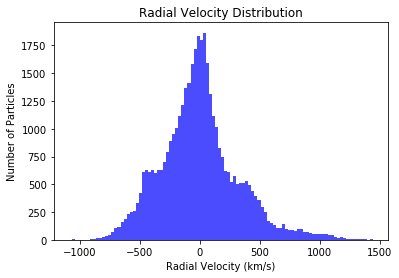

Average outflow divergence at snap=25, galaxy id=96803, halo id=1559: [-241.91301655 -212.57902296 -225.23514446 ... 1442.31962261 2418.21442812
  239.28908743]


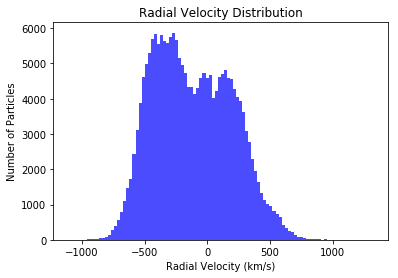

Average outflow divergence at snap=33, galaxy id=96564, halo id=408: [-241.91301655 -212.57902296 -225.23514446 ... 1442.31962261 2418.21442812
  239.28908743]


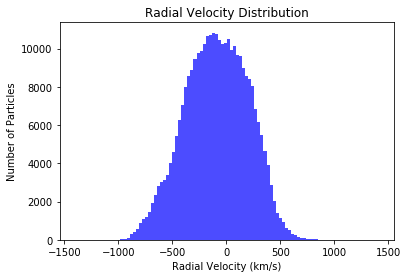

Average outflow divergence at snap=40, galaxy id=120141, halo id=308: [-241.91301655 -212.57902296 -225.23514446 ... 1442.31962261 2418.21442812
  239.28908743]


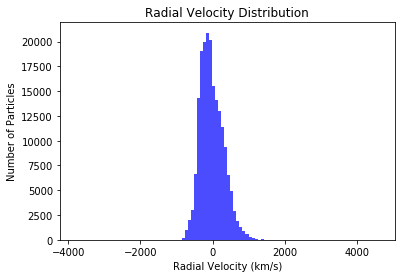

Average outflow divergence at snap=50, galaxy id=201642, halo id=472: [-241.91301655 -212.57902296 -225.23514446 ... 1442.31962261 2418.21442812
  239.28908743]


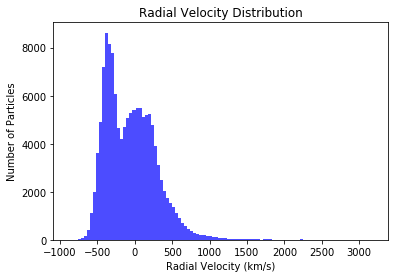

Average outflow divergence at snap=59, galaxy id=240958, halo id=447: [-241.91301655 -212.57902296 -225.23514446 ... 1442.31962261 2418.21442812
  239.28908743]


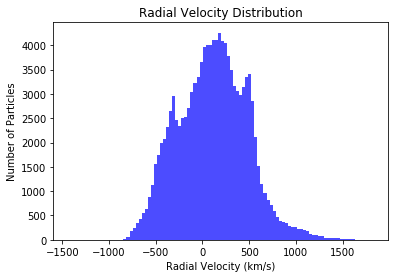

Average outflow divergence at snap=67, galaxy id=278074, halo id=456: [-241.91301655 -212.57902296 -225.23514446 ... 1442.31962261 2418.21442812
  239.28908743]


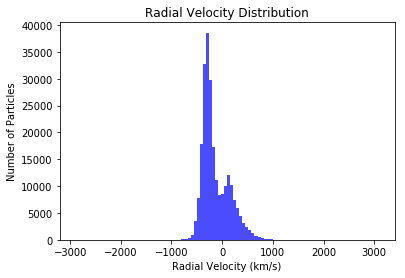

Average outflow divergence at snap=72, galaxy id=271683, halo id=327: [-241.91301655 -212.57902296 -225.23514446 ... 1442.31962261 2418.21442812
  239.28908743]


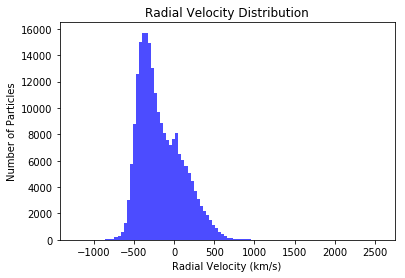

Average outflow divergence at snap=78, galaxy id=288976, halo id=306: [-241.91301655 -212.57902296 -225.23514446 ... 1442.31962261 2418.21442812
  239.28908743]


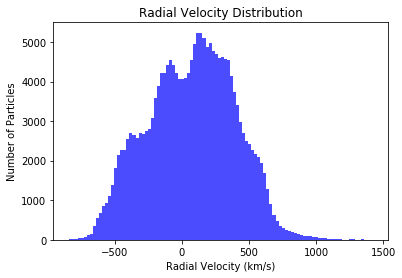

Average outflow divergence at snap=84, galaxy id=311161, halo id=305: [-241.91301655 -212.57902296 -225.23514446 ... 1442.31962261 2418.21442812
  239.28908743]


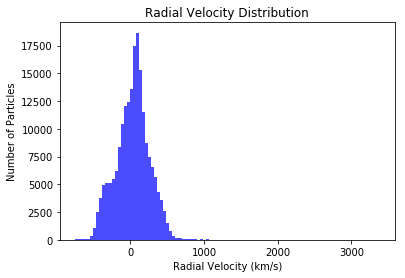

Average outflow divergence at snap=91, galaxy id=328073, halo id=285: [-241.91301655 -212.57902296 -225.23514446 ... 1442.31962261 2418.21442812
  239.28908743]


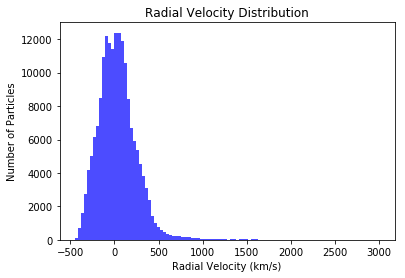

Average outflow divergence at snap=99, galaxy id=356678, halo id=307: [-241.91301655 -212.57902296 -225.23514446 ... 1442.31962261 2418.21442812
  239.28908743]


In [42]:
def visualize_gas_flow(part_data, agn_position):
    # Calculate the position of the particles relative to the AGN
    relative_pos = part_data['Coordinates'] - agn_position
    distances = np.linalg.norm(relative_pos, axis=1)
    
    # Calculate the radial velocities
    radial_velocities = np.sum(relative_pos * part_data['Velocities'], axis=1) / distances
    
    # Plot radial velocity distribution
    plt.hist(radial_velocities, bins=100, color='blue', alpha=0.7)
    plt.xlabel('Radial Velocity (km/s)')
    plt.ylabel('Number of Particles')
    plt.title('Radial Velocity Distribution')
    plt.show()

# Loop over each subhalo ID and their snapshot
for snap, i in zip(snapshots, ids):
    # Get the main halo ID (Group Number) for the subhalo
    main_halo_id = il.groupcat.loadSingle(basePath, snap, subhaloID=i)['SubhaloGrNr']
    
    # Load the properties of the main halo
    main_halo_properties = il.groupcat.loadSingle(basePath, snap, haloID=main_halo_id)
    
    # Get the position of the main halo
    agn_position = main_halo_properties['GroupPos']
    
    # Load the particle data for the halo
    part_data = il.snapshot.loadHalo(basePath, snap, main_halo_id, partType='gas', fields=['Coordinates', 'Velocities'])
    
    # Visualize the gas flow
    visualize_gas_flow(part_data, agn_position)

    # Print the average outflow divergence
    print(f'Average outflow divergence at snap={snap}, galaxy id={i}, halo id={main_halo_id}: {radial_velocities}')

In [43]:
def calculate_radial_velocity(positions, velocities, agn_position):
    # Calculate the relative positions and distances of the particles
    relative_positions = positions - agn_position
    distances = np.linalg.norm(relative_positions, axis=1)

    # Calculate the radial velocities
    radial_velocities = np.sum(relative_positions * velocities, axis=1) / distances

    return radial_velocities

# Define lists to store the results
average_radial_velocity_list = []


# Loop over each subhalo ID and there snapshot
for snap, i in zip(snapshots, ids):
    # Get the main halo ID (Group Number) for the subhalo
    main_halo_id = il.groupcat.loadSingle(basePath, snap, subhaloID=i)['SubhaloGrNr']
    
    # Load the properties of the main halo
    main_halo_properties = il.groupcat.loadSingle(basePath, snap, haloID=main_halo_id)
    
    # Get the position of the main halo
    agn_position = main_halo_properties['GroupPos']
    
    # Load the particle data for the halo
    part_data = il.snapshot.loadHalo(basePath, snap, main_halo_id, partType='gas', fields=['Coordinates', 'Velocities'])

    # Calculate the radial velocities
    radial_velocities = calculate_radial_velocity(part_data['Coordinates'], part_data['Velocities'], agn_position)

    # Calculate the average radial velocity
    average_radial_velocity = np.mean(radial_velocities)
    
    average_radial_velocity_list.append(average_radial_velocity)

    # Print the average radial velocity
    print(f'Average radial velocity at snap={snap}, id={i}, halo id={main_halo_id}: {average_radial_velocity}')
    
df = pd.read_csv('TNG_356678.csv')
df['Average radial velocity'] = average_radial_velocity_list
df.to_csv('TNG_356678.csv', index=False)

Average radial velocity at snap=25, id=96803, halo id=1559: -2.9382014594098673
Average radial velocity at snap=33, id=96564, halo id=408: -116.28674115270469
Average radial velocity at snap=40, id=120141, halo id=308: -90.0115238480109
Average radial velocity at snap=50, id=201642, halo id=472: -21.82044275556473
Average radial velocity at snap=59, id=240958, halo id=447: -53.23633741522965
Average radial velocity at snap=67, id=278074, halo id=456: 109.34371169950631
Average radial velocity at snap=72, id=271683, halo id=327: -139.63957871811675
Average radial velocity at snap=78, id=288976, halo id=306: -173.53779382844962
Average radial velocity at snap=84, id=311161, halo id=305: 72.01256520190039
Average radial velocity at snap=91, id=328073, halo id=285: 35.2134157474292
Average radial velocity at snap=99, id=356678, halo id=307: 37.693491101592976


In [14]:
# List to store BH masses
bhmass_values = []

fields = 'BH_Mass'

# Loop over each subhalo ID and there snapshot
for snap, id in zip(snapshots, ids):
    # Load the BH data for this snapshot and subhalo ID.
    bh_data = il.snapshot.loadSubhalo(basePath, snap, id, "BH", fields=fields)

    # Calculate the BH mass.
    if isinstance(bh_data, np.ndarray) and bh_data.size > 0:  # Check if bh_data is a non-empty array.
        bh_mass = bh_data[0] * ((1e10) / h) #covert the bh mases
    elif isinstance(bh_data, dict) and 'BH_Mass' in bh_data and len(bh_data['BH_Mass']) > 0:  # Check if there is BH data.
        bh_mass = bh_data['BH_Mass'][0] * ((1e10) / h)
    else:  # If no BH data, set the BH mass to zero.
        bh_mass = 0.0
        
    #covert the bh masess to log10 
    bh_mass = np.log10(bh_mass)

    # Append the BH mass to the list.
    bhmass_values.append(bh_mass)
    
    print(f'Blackhole Masses at snap={snap}, id={id}: {bh_mass}')
    
df = pd.read_csv('TNG_356678.csv')
df['Blackhole Masses'] = bhmass_values
df.to_csv('TNG_356678.csv', index=False)

Blackhole Masses at snap=25, id=96803: 6.370173778762788
Blackhole Masses at snap=33, id=96564: 7.370328908410828
Blackhole Masses at snap=40, id=120141: 8.432381531927017
Blackhole Masses at snap=50, id=201642: 8.464915414905404
Blackhole Masses at snap=59, id=240958: 8.644740541490659
Blackhole Masses at snap=67, id=278074: 8.645741205204855
Blackhole Masses at snap=72, id=271683: 8.646309811009512
Blackhole Masses at snap=78, id=288976: 8.787479553489995
Blackhole Masses at snap=84, id=311161: 8.787574060327197
Blackhole Masses at snap=91, id=328073: 8.78775098135487
Blackhole Masses at snap=99, id=356678: 8.905788928250107


In [16]:
# List to store BHmdot
bhmdot_values = []

fields = 'BH_Mdot'

# Loop over each subhalo ID and there snapshot
for snap, id in zip(snapshots, ids):
    # Load the BH data for this snapshot and subhalo ID.
    bh_data = il.snapshot.loadSubhalo(basePath, snap, id, "BH", fields=fields)

    # Calculate the BHmdot.
    if isinstance(bh_data, np.ndarray) and bh_data.size > 0:  # Check if bh_data is a non-empty array.
        bh_dot = bh_data[0] * ((1e10 * Msun) / (h * Gyr_to_s)) #covert the BHmdot
    elif isinstance(bh_data, dict) and 'BH_Mdot' in bh_data and len(bh_data['BH_Mdot']) > 0:  # Check if there is BH data.
        bh_dot = bh_data['BH_Mdot'][0] * ((1e10 * Msun) / (h * Gyr_to_s))
    else:  # If no BH data, set the BHmdot to zero.
        bh_dot = 0.0
        
    #covert the BHmdot to log10 
    bh_dot = np.log10(bh_dot)

    # Append the BHmdot to the list.
    bhmdot_values.append(bh_dot)
    
    
# Print the BHmdot
print("Bhmdot:")
print(len(bhmdot_values)) 

df = pd.read_csv('TNG_356678.csv')
df['Bhmdot'] = bhmdot_values
df.to_csv('TNG_356678.csv', index=False)

Bhmdot:
11


In [17]:
# List to store Star formation rate
sfr_values = []

# Loop over each subhalo ID and there snapshot
for snap, i in zip(snapshots, ids):
    #load the galaxies
    sfr = il.groupcat.loadSingle(basePath, snap, subhaloID=i)
    #extract the value of the sfr
    sfr_value = sfr['SubhaloSFRinHalfRad']
    sfr_values.append(sfr_value)
    print(f'Subhalo SFR at snap={snap}, id={i}: {sfr_value}')

df = pd.read_csv('TNG_356678.csv')
df['SFR'] = sfr_values
df.to_csv('TNG_356678.csv', index=False)

Subhalo SFR at snap=25, id=96803: 10.680899620056152
Subhalo SFR at snap=33, id=96564: 6.569467067718506
Subhalo SFR at snap=40, id=120141: 7.045799732208252
Subhalo SFR at snap=50, id=201642: 4.465848922729492
Subhalo SFR at snap=59, id=240958: 0.5010089874267578
Subhalo SFR at snap=67, id=278074: 0.5450125336647034
Subhalo SFR at snap=72, id=271683: 0.0
Subhalo SFR at snap=78, id=288976: 0.0
Subhalo SFR at snap=84, id=311161: 0.0
Subhalo SFR at snap=91, id=328073: 0.0045074354857206345
Subhalo SFR at snap=99, id=356678: 0.0


In [18]:
# Create empty list to store of fraction χ of the Eddington accretion rate values
χ_rate_list = []

fields=["BH_Mass", "BH_Mdot", "BH_MdotEddington"]

# Loop over each subhalo ID and there snapshot
for snapshot, id in zip(snapshots, ids):
    # Load black hole properties for specific subhalo
    blackholes = il.snapshot.loadSubhalo(basePath, snapshot, id, "BH", fields=fields)
    
    # Calculate the BHdot.
    if isinstance(blackholes, np.ndarray) and blackholes.size > 0 and blackholes['BH_Mdot'][0] != 0:  
        bhdot = blackholes['BH_Mdot'][0]
    elif isinstance(blackholes, dict) and 'BH_Mdot' in blackholes and len(blackholes['BH_Mdot']) > 0 and blackholes['BH_Mdot'][0] != 0: 
        bhdot = blackholes['BH_Mdot'][0]
    else:  
        bhdot = np.nan  # Set to np.nan so that the resulting χ_rate will be np.nan.
        
    # Calculate the BH eddington.
    if isinstance(blackholes, np.ndarray) and blackholes.size > 0 and blackholes['BH_MdotEddington'][0] != 0:  
        bhedd = blackholes['BH_MdotEddington'][0]
    elif isinstance(blackholes, dict) and 'BH_MdotEddington' in blackholes and len(blackholes['BH_MdotEddington']) > 0 and blackholes['BH_MdotEddington'][0] != 0:  
        bhedd = blackholes['BH_MdotEddington'][0]
    else:  
        bhedd = np.nan  # Set to np.nan so that the resulting χ_rate will be np.nan.

        
    # Calculate χ_rate
    χ_rate = (bhdot / bhedd)

    
    # Append χ_rate to the list
    χ_rate_list.append(χ_rate)


# Print fraction χ values
print("χ values:")
print(χ_rate_list)

df = pd.read_csv('TNG_356678.csv')
df['χ'] = χ_rate_list
df.to_csv('TNG_356678.csv', index=False)

χ values:
[0.1272362718376173, 0.06462044933285588, 0.037918104279350134, 0.0015298769151240034, 8.037821224018839e-05, 0.00011252791718308706, 4.305816027828831e-06, 7.129093103726728e-05, 1.0071976263136576e-05, 2.5737570410538862e-05, 0.00010184179276810813]


In [19]:
# Create empty list to store the bolometric luminosity values
L_list = []

fields=["BH_Mass", "BH_Mdot"]

# Loop over each subhalo ID and there snapshot
for snapshot, id in zip(snapshots, ids):
    # Load black hole properties for specific subhalo
    blackholes = il.snapshot.loadSubhalo(basePath, snapshot, id, "BH", fields=fields)
    
    # Calculate the BHdot.
    if isinstance(blackholes, np.ndarray) and blackholes.size > 0 and blackholes['BH_Mdot'][0] != 0:  
        bhdot = blackholes['BH_Mdot'][0] * ((1e10 * Msun) / (h * Gyr_to_s))
    elif isinstance(blackholes, dict) and 'BH_Mdot' in blackholes and len(blackholes['BH_Mdot']) > 0 and blackholes['BH_Mdot'][0] != 0: 
        bhdot = blackholes['BH_Mdot'][0] * ((1e10 * Msun) / (h * Gyr_to_s))
    else:  
        bhdot = np.nan  # Set to np.nan so that the resulting L_bol will be np.nan.

    # Calculate L_bol
    L_bol = e_r * bhdot * c**2

    
    # Append bolometric luminosity to the list
    L_list.append(np.log10(L_bol))


# Print bolometric luminosity values
print("Bol Luminosity values:")
print(L_list)

df = pd.read_csv('TNG_356678.csv')
df['L_bol'] = L_list
df.to_csv('TNG_356678.csv', index=False)

Bol Luminosity values:
[43.733582485092974, 44.43953228909794, 45.27007952986092, 43.90842568093318, 42.80873429982899, 42.955856834591486, 41.539220821504145, 42.899369270826, 42.049544302222266, 42.457174054736804, 43.17257029461477]


In [20]:
# Create empty list to store the Eddington luminosity values
L_edd_list = []

e_r = 0.2

fields=["BH_Mass", "BH_MdotEddington"]

# Loop over each subhalo ID and there snapshot
for snapshot, id in zip(snapshots, ids):
    # Load black hole properties for specific subhalo
    blackholes = il.snapshot.loadSubhalo(basePath, snapshot, id, "BH", fields=fields)
    
    # Calculate the BH eddington.
    if isinstance(blackholes, np.ndarray) and blackholes.size > 0 and blackholes['BH_MdotEddington'][0] != 0:  
        bhedd = blackholes['BH_MdotEddington'][0] * ((1e10 * Msun) / (h * Gyr_to_s))
    elif isinstance(blackholes, dict) and 'BH_MdotEddington' in blackholes and len(blackholes['BH_MdotEddington']) > 0 and blackholes['BH_MdotEddington'][0] != 0: 
        bhedd = blackholes['BH_MdotEddington'][0] * ((1e10 * Msun) / (h * Gyr_to_s))
    else:  
        bhedd = np.nan  # Set to np.nan so that the resulting L_edd will be np.nan.


    # Calculate L_edd
    L_edd = e_r * bhedd * c**2

    
    # Append Eddington luminosity to the list
    L_edd_list.append(np.log10(L_edd))


# Print Eddington luminosity values
print("Edd Luminosity values:")
print(L_edd_list)

df = pd.read_csv('TNG_356678.csv')
df['L_edd'] = L_edd_list
df.to_csv('TNG_356678.csv', index=False)

Edd Luminosity values:
[44.6289715497761, 45.629162315575684, 46.69123291326235, 46.72376918948338, 46.9035959573765, 46.90459655414875, 46.90516535147548, 47.046334984325846, 47.04642960863328, 47.04660650700516, 47.164644258815564]


In [21]:
# Create empty list to store the feedback energy of the AGN values
E_feed_list = []


Msun = 1.989e33 # in grams
Gyr_to_s = 3.15576e16 # in seconds
h = 0.6774

fields=["BH_Mass", "BH_Mdot"]

# Loop over each subhalo ID and there snapshot
for snapshot, id in zip(snapshots, ids):
    # Load black hole properties for specific subhalo
    blackholes = il.snapshot.loadSubhalo(basePath, snapshot, id, "BH", fields=fields)
    
    # Calculate the BHdot.
    if isinstance(blackholes, np.ndarray) and blackholes.size > 0 and blackholes['BH_Mdot'][0] != 0:  
        bhdot = blackholes['BH_Mdot'][0] * ((1e10 * Msun) / (h * Gyr_to_s))
    elif isinstance(blackholes, dict) and 'BH_Mdot' in blackholes and len(blackholes['BH_Mdot']) > 0 and blackholes['BH_Mdot'][0] != 0: 
        bhdot = blackholes['BH_Mdot'][0] * ((1e10 * Msun) / (h * Gyr_to_s))
    else:  
        bhdot = np.nan  # Set to np.nan so that the resulting feedback energy will be np.nan.

        
    # Calculate feedback energy
    E_feed = e_fm * bhdot * c**2

    
    # Append feedback energy to the list
    E_feed_list.append(np.log10(E_feed))


# Print feedback energy values
print("E_feed values:")
print(E_feed_list)

df = pd.read_csv('TNG_356678.csv')
df['E_feed'] = E_feed_list
df.to_csv('TNG_356678.csv', index=False)

E_feed values:
[43.733582485092974, 44.43953228909794, 45.27007952986092, 43.90842568093318, 42.80873429982899, 42.955856834591486, 41.539220821504145, 42.899369270826, 42.049544302222266, 42.457174054736804, 43.17257029461477]


In [22]:
# Prepare empty lists to store the logarithm values
QM_values = []
RM_values = []

# Loop over each subhalo ID and their snapshot
for snapshot, id in zip(snapshots, ids):
    # Load necessary fields
    fields = ['BH_CumEgyInjection_QM', 'BH_CumEgyInjection_RM']
    data = il.snapshot.loadSubhalo(basePath, snapshot, id, 'BH', fields=fields)
    
    # Convert units
    BH_CumEgyInjection_QM_phys = np.sqrt(data['BH_CumEgyInjection_QM'] * 1e10 / 0.7 / (0.978 / 0.7)**2)
    BH_CumEgyInjection_RM_phys = np.sqrt(data['BH_CumEgyInjection_RM'] * 1e10 / 0.7 / (0.978 / 0.7)**2)

    # Calculate the logarithm and replace -inf with 0
    QM_log = np.log10(BH_CumEgyInjection_QM_phys)
    RM_log = np.log10(BH_CumEgyInjection_RM_phys)
    
    QM_log[np.isneginf(QM_log)] = 0
    RM_log[np.isneginf(RM_log)] = 0

    QM_values.append(QM_log[0])  # Only store the first (and only) value in the array
    RM_values.append(RM_log[0])  # Only store the first (and only) value in the array

    print(f'Logarithmic QM and RM at snap={snapshot}, id={id}: {QM_log[0]}, {RM_log[0]}')
    
df = pd.read_csv('TNG_356678.csv')
df['Log_EQM'] = QM_values
df['Log_ERM'] = RM_values
df.to_csv('TNG_356678.csv', index=False)

Logarithmic QM and RM at snap=25, id=96803: 7.556433713848855, 0.0
Logarithmic QM and RM at snap=33, id=96564: 8.197371914880465, 0.0
Logarithmic QM and RM at snap=40, id=120141: 8.735696139150791, 7.554584806730827
Logarithmic QM and RM at snap=50, id=201642: 8.747127644491538, 8.34704293231268
Logarithmic QM and RM at snap=59, id=240958: 8.837499172419474, 8.448783889357728
Logarithmic QM and RM at snap=67, id=278074: 8.837499172419474, 8.477912683209903
Logarithmic QM and RM at snap=72, id=271683: 8.837499172419474, 8.492900304714018
Logarithmic QM and RM at snap=78, id=288976: 8.909643347364911, 8.501751555054366
Logarithmic QM and RM at snap=84, id=311161: 8.909643347364911, 8.50490701806866
Logarithmic QM and RM at snap=91, id=328073: 8.909643347364911, 8.510687559180933
Logarithmic QM and RM at snap=99, id=356678: 8.968669421430858, 8.571716392587753


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10


In [16]:
#lets view the compilation of the file 
df = pd.read_csv('TNG_356678.csv')
print(df.head())

   Redshift (z)  Average divergence  Average radial velocity  \
0           3.0           -2.514770               -59.051962   
1           2.0           -8.658848               -56.661693   
2           1.5           -7.134847               -58.604299   
3           1.0            1.663542               -61.221945   
4           0.7           -1.718992               -32.015236   

   Blackhole Masses     Bhmdot        SFR         χ      L_bol      L_edd  \
0          6.370174  23.478911  10.680900  0.127236  43.733582  44.628972   
1          7.370329  24.184861   6.569467  0.064620  44.439532  45.629162   
2          8.432382  25.015408   7.045800  0.037918  45.270080  46.691233   
3          8.464915  23.653754   4.465849  0.001530  43.908426  46.723769   
4          8.644741  22.554063   0.501009  0.000080  42.808734  46.903596   

      E_feed   Log_EQM   Log_ERM  Average divergence of Halo  
0  43.733582  7.556434  0.000000                   -1.850562  
1  44.439532  8.197372  0.

---------------------------------------

### Next galaxy is id=359811

##### same process as the above

In [44]:
ids = [359811] #galaxy id
target_snaps = [99, 91, 84, 78, 72, 67, 59, 50, 40, 33, 25]  # list of target snapshots here
# the target snapshots list are the 11 out the 20 full snapshots that illustrisTNG have 
# 99 snapshots corresponds to z=0 and the 25 snapshot to z=3

progenitor_ids_list = []

for id in ids:
    id_progenitors = []
    start_url = "http://www.tng-project.org/api/TNG100-1/snapshots/99/subhalos/" + str(id)
    sub = get(start_url)
    current_snap = 99

    for snap in target_snaps:
        while current_snap > snap:
            # request the full subhalo details of the progenitor by following the sublink URL
            try:
                sub = get(sub['related']['sublink_progenitor'])
                current_snap = sub['snap']
            except KeyError:  # KeyError occurs if there's no progenitor
                break  # exit the while loop and go to the next snap

        if current_snap == snap:  # if the snapshot has a progenitor
            id_progenitors.append(sub['id'])
            print(f'Progenitor of {id} at snap={snap} is {sub["id"]}')
        else:
            print(f'Progenitor of {id} not followed to snap={snap}!')
            id_progenitors.append(-1)

    progenitor_ids_list.append(id_progenitors)

# Transpose the list to match the target_snap order
progenitor_ids_list = list(map(list, zip(*progenitor_ids_list)))

# Exclude -1 values
progenitor_ids_list = [sublist for sublist in progenitor_ids_list if sublist != [-1]*len(ids)]

# Flatten the list
progenitor_ids_list = [id for sublist in progenitor_ids_list for id in sublist]

# Reverse the list
progenitor_ids_list.reverse()

print(progenitor_ids_list)

Progenitor of 359811 at snap=99 is 359811
Progenitor of 359811 at snap=91 is 338697
Progenitor of 359811 at snap=84 is 319869
Progenitor of 359811 at snap=78 is 294528
Progenitor of 359811 at snap=72 is 273082
Progenitor of 359811 at snap=67 is 249122
Progenitor of 359811 at snap=59 is 212733
Progenitor of 359811 at snap=50 is 174022
Progenitor of 359811 at snap=40 is 197345
Progenitor of 359811 at snap=33 is 126942
Progenitor of 359811 at snap=25 is 49799
[49799, 126942, 197345, 174022, 212733, 249122, 273082, 294528, 319869, 338697, 359811]


In [45]:
# target snapshots
snapshots = [25, 33, 40, 50, 59, 67, 72, 78, 84, 91, 99]
print(snapshots)
#below are the ids that were found from above
ids = progenitor_ids_list
print(ids)

[25, 33, 40, 50, 59, 67, 72, 78, 84, 91, 99]
[49799, 126942, 197345, 174022, 212733, 249122, 273082, 294528, 319869, 338697, 359811]


In [26]:
#Redshift are stored in the list `redshift`
redshift = [3, 2, 1.5, 1, 0.7, 0.5, 0.4, 0.3, 0.2, 0.1, 0]

# Create a DataFrame from your data
df = pd.DataFrame({
    'Redshift (z)': redshift
})

# Write the DataFrame to a CSV file
df.to_csv('TNG_359811.csv', index=False)

In [16]:
def calculate_divergence(part_data, agn_position):
    # Calculate the position of the particles relative to the AGN
    relative_pos = part_data['Coordinates'] - agn_position

    # Calculate the position boundaries
    padding = 1  # This value can be adhust as needed
    min_x, min_y, min_z = np.min(relative_pos, axis=0) - padding
    max_x, max_y, max_z = np.max(relative_pos, axis=0) + padding

    # Create a grid
    grid_x, grid_y, grid_z = np.mgrid[min_x:max_x:100j, min_y:max_y:100j, min_z:max_z:100j]

    # Interpolate the velocities onto the grid
    grid_vx = interpolate.griddata(relative_pos, part_data['Velocities'][:, 0], (grid_x, grid_y, grid_z), method='nearest')
    grid_vy = interpolate.griddata(relative_pos, part_data['Velocities'][:, 1], (grid_x, grid_y, grid_z), method='nearest')
    grid_vz = interpolate.griddata(relative_pos, part_data['Velocities'][:, 2], (grid_x, grid_y, grid_z), method='nearest')

    # Calculate the divergence
    divergence = np.gradient(grid_vx, axis=0) + np.gradient(grid_vy, axis=1) + np.gradient(grid_vz, axis=2)
    
    # Return the average divergence    
    return np.mean(divergence)

# Define lists to store the results
avg_divergence_list = []

# Loop over each subhalo ID and there snapshot
for snap, i in zip(snapshots, ids):
    # Load the particle data for the subhalo
    part_data = il.snapshot.loadSubhalo(basePath, snap, i, partType='gas', fields=['Coordinates', 'Velocities'])
    
    agn_position = il.groupcat.loadSingle(basePath, snap, subhaloID=i)
    agn_position = agn_position['SubhaloPos']

    # Calculate the divergence
    average_divergence = calculate_divergence(part_data, agn_position)

    # Store the results
    avg_divergence_list.append(average_divergence)

    # Print the average divergence
    print(f'Average divergence at snap={snap}, id={i}: {average_divergence}')
#read the file    
df = pd.read_csv('TNG_359811.csv')
#append them to the new column 
df['Average divergence'] = avg_divergence_list
df.to_csv('TNG_359811.csv', index=False)

Average divergence at snap=25, id=49799: -9.89590388656503
Average divergence at snap=33, id=126942: 0.5538550057210475
Average divergence at snap=40, id=197345: -1.918578351872921
Average divergence at snap=50, id=174022: 0.4811434569430351
Average divergence at snap=59, id=212733: -3.3187322060286255
Average divergence at snap=67, id=249122: -4.453222958387107
Average divergence at snap=72, id=273082: -2.2050028785291054
Average divergence at snap=78, id=294528: -0.9650238176932335
Average divergence at snap=84, id=319869: -1.4605270234358907
Average divergence at snap=91, id=338697: -2.1267182803992855
Average divergence at snap=99, id=359811: -1.3723239656087756


In [17]:
def calculate_divergence(part_data, agn_position):
    # Calculate the position of the particles relative to the AGN
    relative_pos = part_data['Coordinates'] - agn_position

    # Calculate the position boundaries
    padding = 1  # This value can be adjusted as needed
    min_x, min_y, min_z = np.min(relative_pos, axis=0) - padding
    max_x, max_y, max_z = np.max(relative_pos, axis=0) + padding

    # Create a grid
    grid_x, grid_y, grid_z = np.mgrid[min_x:max_x:100j, min_y:max_y:100j, min_z:max_z:100j]

    # Interpolate the velocities onto the grid
    grid_vx = interpolate.griddata(relative_pos, part_data['Velocities'][:, 0], (grid_x, grid_y, grid_z), method='nearest')
    grid_vy = interpolate.griddata(relative_pos, part_data['Velocities'][:, 1], (grid_x, grid_y, grid_z), method='nearest')
    grid_vz = interpolate.griddata(relative_pos, part_data['Velocities'][:, 2], (grid_x, grid_y, grid_z), method='nearest')

    # Calculate the divergence
    divergence = np.gradient(grid_vx, axis=0) + np.gradient(grid_vy, axis=1) + np.gradient(grid_vz, axis=2)
    
    # Return the average divergence    
    return np.mean(divergence)

# Define lists to store the results
avg_divergence_list = []

# Loop over each subhalo ID and their snapshot
for snap, i in zip(snapshots, ids):
    # Get the main halo ID (Group Number) for the subhalo
    main_halo_id = il.groupcat.loadSingle(basePath, snap, subhaloID=i)['SubhaloGrNr']
    
    # Load the properties of the main halo
    main_halo_properties = il.groupcat.loadSingle(basePath, snap, haloID=main_halo_id)
    
    # Get the position of the main halo
    agn_position = main_halo_properties['GroupPos']
    
    # Load the particle data for the halo
    part_data = il.snapshot.loadHalo(basePath, snap, main_halo_id, partType='gas', fields=['Coordinates', 'Velocities'])

    # Calculate the divergence
    average_divergence = calculate_divergence(part_data, agn_position)

    # Store the results
    avg_divergence_list.append(average_divergence)

    # Print the average divergence
    print(f'Average divergence at snap={snap}, galaxy id={i}, halo id={main_halo_id}: {average_divergence}')
#read the file    
df = pd.read_csv('TNG_359811.csv')
#append them to the new column 
df['Average divergence of Halo'] = avg_divergence_list
df.to_csv('TNG_359811.csv', index=False)

Average divergence at snap=25, galaxy id=49799, halo id=430: -9.932913760241568
Average divergence at snap=33, galaxy id=126942, halo id=750: 6.270533987825393
Average divergence at snap=40, galaxy id=197345, halo id=1063: 11.122477331091403
Average divergence at snap=50, galaxy id=174022, halo id=320: -1.9596908479932547
Average divergence at snap=59, galaxy id=212733, halo id=306: -2.322404931601271
Average divergence at snap=67, galaxy id=249122, halo id=314: -4.426787411938697
Average divergence at snap=72, galaxy id=273082, halo id=333: -2.1302142467596865
Average divergence at snap=78, galaxy id=294528, halo id=329: -0.6422435652596951
Average divergence at snap=84, galaxy id=319869, halo id=341: -1.0763225282300115
Average divergence at snap=91, galaxy id=338697, halo id=327: -2.01090569406005
Average divergence at snap=99, galaxy id=359811, halo id=319: -1.1613946297988296


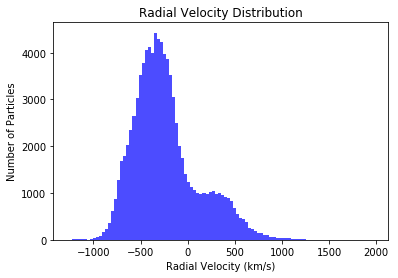

Average outflow divergence at snap=25, galaxy id=49799, halo id=430: [-241.91301655 -212.57902296 -225.23514446 ... 1442.31962261 2418.21442812
  239.28908743]


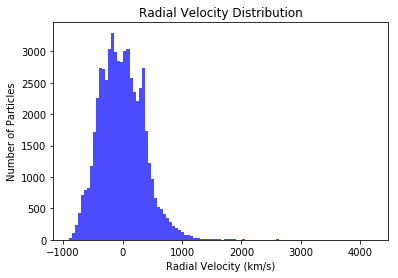

Average outflow divergence at snap=33, galaxy id=126942, halo id=750: [-241.91301655 -212.57902296 -225.23514446 ... 1442.31962261 2418.21442812
  239.28908743]


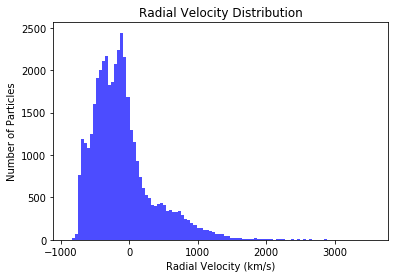

Average outflow divergence at snap=40, galaxy id=197345, halo id=1063: [-241.91301655 -212.57902296 -225.23514446 ... 1442.31962261 2418.21442812
  239.28908743]


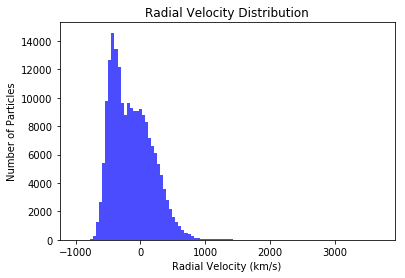

Average outflow divergence at snap=50, galaxy id=174022, halo id=320: [-241.91301655 -212.57902296 -225.23514446 ... 1442.31962261 2418.21442812
  239.28908743]


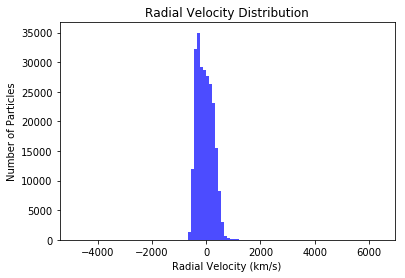

Average outflow divergence at snap=59, galaxy id=212733, halo id=306: [-241.91301655 -212.57902296 -225.23514446 ... 1442.31962261 2418.21442812
  239.28908743]


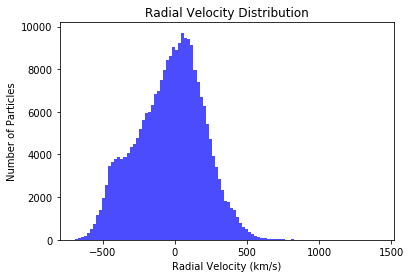

Average outflow divergence at snap=67, galaxy id=249122, halo id=314: [-241.91301655 -212.57902296 -225.23514446 ... 1442.31962261 2418.21442812
  239.28908743]


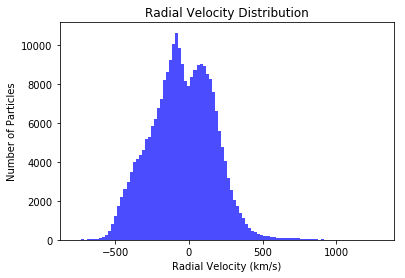

Average outflow divergence at snap=72, galaxy id=273082, halo id=333: [-241.91301655 -212.57902296 -225.23514446 ... 1442.31962261 2418.21442812
  239.28908743]


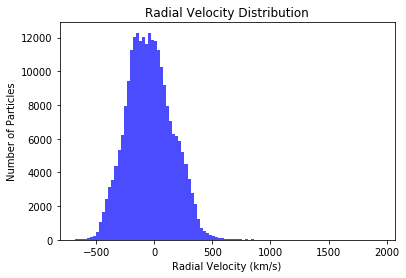

Average outflow divergence at snap=78, galaxy id=294528, halo id=329: [-241.91301655 -212.57902296 -225.23514446 ... 1442.31962261 2418.21442812
  239.28908743]


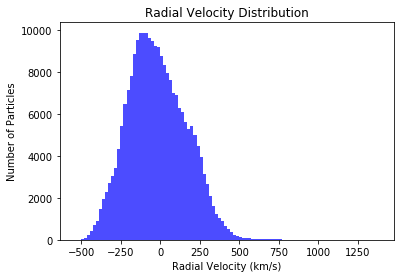

Average outflow divergence at snap=84, galaxy id=319869, halo id=341: [-241.91301655 -212.57902296 -225.23514446 ... 1442.31962261 2418.21442812
  239.28908743]


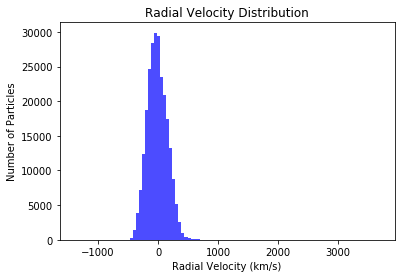

Average outflow divergence at snap=91, galaxy id=338697, halo id=327: [-241.91301655 -212.57902296 -225.23514446 ... 1442.31962261 2418.21442812
  239.28908743]


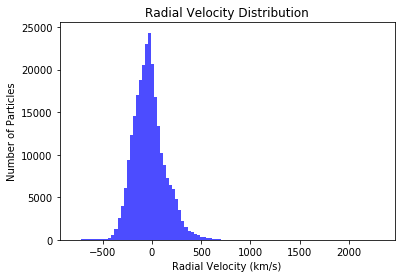

Average outflow divergence at snap=99, galaxy id=359811, halo id=319: [-241.91301655 -212.57902296 -225.23514446 ... 1442.31962261 2418.21442812
  239.28908743]


In [46]:
def visualize_gas_flow(part_data, agn_position):
    # Calculate the position of the particles relative to the AGN
    relative_pos = part_data['Coordinates'] - agn_position
    distances = np.linalg.norm(relative_pos, axis=1)
    
    # Calculate the radial velocities
    radial_velocities = np.sum(relative_pos * part_data['Velocities'], axis=1) / distances
    
    # Plot radial velocity distribution
    plt.hist(radial_velocities, bins=100, color='blue', alpha=0.7)
    plt.xlabel('Radial Velocity (km/s)')
    plt.ylabel('Number of Particles')
    plt.title('Radial Velocity Distribution')
    plt.show()

# Loop over each subhalo ID and their snapshot
for snap, i in zip(snapshots, ids):
    # Get the main halo ID (Group Number) for the subhalo
    main_halo_id = il.groupcat.loadSingle(basePath, snap, subhaloID=i)['SubhaloGrNr']
    
    # Load the properties of the main halo
    main_halo_properties = il.groupcat.loadSingle(basePath, snap, haloID=main_halo_id)
    
    # Get the position of the main halo
    agn_position = main_halo_properties['GroupPos']
    
    # Load the particle data for the halo
    part_data = il.snapshot.loadHalo(basePath, snap, main_halo_id, partType='gas', fields=['Coordinates', 'Velocities'])
    
    # Visualize the gas flow
    visualize_gas_flow(part_data, agn_position)

    # Print the average outflow divergence
    print(f'Average outflow divergence at snap={snap}, galaxy id={i}, halo id={main_halo_id}: {radial_velocities}')

In [47]:
def calculate_radial_velocity(positions, velocities, agn_position):
    # Calculate the relative positions and distances of the particles
    relative_positions = positions - agn_position
    distances = np.linalg.norm(relative_positions, axis=1)

    # Calculate the radial velocities
    radial_velocities = np.sum(relative_positions * velocities, axis=1) / distances

    return radial_velocities

# Define lists to store the results
average_radial_velocity_list = []


# Loop over each subhalo ID and there snapshot
for snap, i in zip(snapshots, ids):
    # Get the main halo ID (Group Number) for the subhalo
    main_halo_id = il.groupcat.loadSingle(basePath, snap, subhaloID=i)['SubhaloGrNr']
    
    # Load the properties of the main halo
    main_halo_properties = il.groupcat.loadSingle(basePath, snap, haloID=main_halo_id)
    
    # Get the position of the main halo
    agn_position = main_halo_properties['GroupPos']
    
    # Load the particle data for the halo
    part_data = il.snapshot.loadHalo(basePath, snap, main_halo_id, partType='gas', fields=['Coordinates', 'Velocities'])

    # Calculate the radial velocities
    radial_velocities = calculate_radial_velocity(part_data['Coordinates'], part_data['Velocities'], agn_position)

    # Calculate the average radial velocity
    average_radial_velocity = np.mean(radial_velocities)
    
    average_radial_velocity_list.append(average_radial_velocity)

    # Print the average radial velocity
    print(f'Average radial velocity at snap={snap}, id={i}, halo id={main_halo_id}: {average_radial_velocity}')
    
df = pd.read_csv('TNG_359811.csv')
df['Average radial velocity'] = average_radial_velocity_list
df.to_csv('TNG_359811.csv', index=False)  

Average radial velocity at snap=25, id=49799, halo id=430: -233.42539525216839
Average radial velocity at snap=33, id=126942, halo id=750: -7.7866250318103445
Average radial velocity at snap=40, id=197345, halo id=1063: -105.50847725793284
Average radial velocity at snap=50, id=174022, halo id=320: -126.96901088978112
Average radial velocity at snap=59, id=212733, halo id=306: -58.702187196503836
Average radial velocity at snap=67, id=249122, halo id=314: -34.2695444719864
Average radial velocity at snap=72, id=273082, halo id=333: -44.947628484453325
Average radial velocity at snap=78, id=294528, halo id=329: -40.393357174476186
Average radial velocity at snap=84, id=319869, halo id=341: -18.550120466204536
Average radial velocity at snap=91, id=338697, halo id=327: -10.568605978591998
Average radial velocity at snap=99, id=359811, halo id=319: -28.30307981920601


In [29]:
# List to store BH masses
bhmass_values = []

fields = 'BH_Mass'

# Loop over each subhalo ID and there snapshot
for snap, id in zip(snapshots, ids):
    # Load the BH data for this snapshot and subhalo ID.
    bh_data = il.snapshot.loadSubhalo(basePath, snap, id, "BH", fields=fields)

    # Calculate the BH mass.
    if isinstance(bh_data, np.ndarray) and bh_data.size > 0:  # Check if bh_data is a non-empty array.
        bh_mass = bh_data[0] * ((1e10) / h) #covert the bh mases
    elif isinstance(bh_data, dict) and 'BH_Mass' in bh_data and len(bh_data['BH_Mass']) > 0:  # Check if there is BH data.
        bh_mass = bh_data['BH_Mass'][0] * ((1e10) / h)
    else:  # If no BH data, set the BH mass to zero.
        bh_mass = 0.0
        
    #covert the bh masess to log10 
    bh_mass = np.log10(bh_mass)

    # Append the BH mass to the list.
    bhmass_values.append(bh_mass)
    
    print(f'Blackhole Masses at snap={snap}, id={id}: {bh_mass}')
    
df = pd.read_csv('TNG_359811.csv')
df['Blackhole Masses'] = bhmass_values
df.to_csv('TNG_359811.csv', index=False)

Blackhole Masses at snap=25, id=49799: 7.366657414040407
Blackhole Masses at snap=33, id=126942: 8.667488480322453
Blackhole Masses at snap=40, id=197345: 8.668608187653929
Blackhole Masses at snap=50, id=174022: 8.669391035651214
Blackhole Masses at snap=59, id=212733: 8.990917052913856
Blackhole Masses at snap=67, id=249122: 8.991682221014932
Blackhole Masses at snap=72, id=273082: 8.991783486096411
Blackhole Masses at snap=78, id=294528: 8.991903853718549
Blackhole Masses at snap=84, id=319869: 8.992011927389374
Blackhole Masses at snap=91, id=338697: 8.99217119092382
Blackhole Masses at snap=99, id=359811: 9.00312047677316


In [30]:
# List to store BHmdot
bhmdot_values = []

fields = 'BH_Mdot'

# Loop over each subhalo ID and there snapshot
for snap, id in zip(snapshots, ids):
    # Load the BH data for this snapshot and subhalo ID.
    bh_data = il.snapshot.loadSubhalo(basePath, snap, id, "BH", fields=fields)

    # Calculate the BHmdot.
    if isinstance(bh_data, np.ndarray) and bh_data.size > 0:  # Check if bh_data is a non-empty array.
        bh_dot = bh_data[0] * ((1e10 * Msun) / (h * Gyr_to_s)) #covert the BHmdot
    elif isinstance(bh_data, dict) and 'BH_Mdot' in bh_data and len(bh_data['BH_Mdot']) > 0:  # Check if there is BH data.
        bh_dot = bh_data['BH_Mdot'][0] * ((1e10 * Msun) / (h * Gyr_to_s))
    else:  # If no BH data, set the BHmdot to zero.
        bh_dot = 0.0
        
    #covert the BHmdot to log10 
    bh_dot = np.log10(bh_dot)

    # Append the BHmdot to the list.
    bhmdot_values.append(bh_dot)
    
    
# Print the BHmdot
print("Bhmdot:")
print(len(bhmdot_values)) 

df = pd.read_csv('TNG_359811.csv')
df['Bhmdot'] = bhmdot_values
df.to_csv('TNG_359811.csv', index=False)

Bhmdot:
11


In [31]:
# List to store Star formation rate
sfr_values = []

# Loop over each subhalo ID and there snapshot
for snap, i in zip(snapshots, ids):
    #load the galaxies
    sfr = il.groupcat.loadSingle(basePath, snap, subhaloID=i)
    #extract the value of the sfr
    sfr_value = sfr['SubhaloSFRinHalfRad']
    sfr_values.append(sfr_value)
    print(f'Subhalo SFR at snap={snap}, id={i}: {sfr_value}')

df = pd.read_csv('TNG_359811.csv')
df['SFR'] = sfr_values
df.to_csv('TNG_359811.csv', index=False)

Subhalo SFR at snap=25, id=49799: 26.90997314453125
Subhalo SFR at snap=33, id=126942: 0.0
Subhalo SFR at snap=40, id=197345: 0.0
Subhalo SFR at snap=50, id=174022: 0.0
Subhalo SFR at snap=59, id=212733: 0.0
Subhalo SFR at snap=67, id=249122: 0.0
Subhalo SFR at snap=72, id=273082: 0.0
Subhalo SFR at snap=78, id=294528: 0.0
Subhalo SFR at snap=84, id=319869: 0.0
Subhalo SFR at snap=91, id=338697: 0.0
Subhalo SFR at snap=99, id=359811: 0.0


In [32]:
# Create empty list to store of fraction χ of the Eddington accretion rate values
χ_rate_list = []

fields=["BH_Mass", "BH_Mdot", "BH_MdotEddington"]

# Loop over each subhalo ID and there snapshot
for snapshot, id in zip(snapshots, ids):
    # Load black hole properties for specific subhalo
    blackholes = il.snapshot.loadSubhalo(basePath, snapshot, id, "BH", fields=fields)
    
    # Calculate the BHdot.
    if isinstance(blackholes, np.ndarray) and blackholes.size > 0 and blackholes['BH_Mdot'][0] != 0:  
        bhdot = blackholes['BH_Mdot'][0]
    elif isinstance(blackholes, dict) and 'BH_Mdot' in blackholes and len(blackholes['BH_Mdot']) > 0 and blackholes['BH_Mdot'][0] != 0: 
        bhdot = blackholes['BH_Mdot'][0]
    else:  
        bhdot = np.nan  # Set to np.nan so that the resulting χ_rate will be np.nan.
        
    # Calculate the BH eddington.
    if isinstance(blackholes, np.ndarray) and blackholes.size > 0 and blackholes['BH_MdotEddington'][0] != 0:  
        bhedd = blackholes['BH_MdotEddington'][0]
    elif isinstance(blackholes, dict) and 'BH_MdotEddington' in blackholes and len(blackholes['BH_MdotEddington']) > 0 and blackholes['BH_MdotEddington'][0] != 0:  
        bhedd = blackholes['BH_MdotEddington'][0]
    else:  
        bhedd = np.nan  # Set to np.nan so that the resulting χ_rate will be np.nan.

        
    # Calculate χ_rate
    χ_rate = (bhdot / bhedd)

    
    # Append χ_rate to the list
    χ_rate_list.append(χ_rate)


# Print fraction χ values
print("χ values:")
print(χ_rate_list)

df = pd.read_csv('TNG_359811.csv')
df['χ'] = χ_rate_list
df.to_csv('TNG_359811.csv', index=False)

χ values:
[0.9437785128844122, 5.092678163174461e-05, 0.000795278345708525, 0.00017886260755723175, 2.5167746898106742e-05, 1.749627837966072e-05, 2.146373742935417e-05, 1.6722361566665907e-05, 2.1009781829697654e-05, 7.099788857854352e-05, 1.9163642633924627e-05]


In [33]:
# Create empty list to store the bolometric luminosity values
L_list = []

fields=["BH_Mass", "BH_Mdot"]

# Loop over each subhalo ID and there snapshot
for snapshot, id in zip(snapshots, ids):
    # Load black hole properties for specific subhalo
    blackholes = il.snapshot.loadSubhalo(basePath, snapshot, id, "BH", fields=fields)
    
    # Calculate the BHdot.
    if isinstance(blackholes, np.ndarray) and blackholes.size > 0 and blackholes['BH_Mdot'][0] != 0:  
        bhdot = blackholes['BH_Mdot'][0] * ((1e10 * Msun) / (h * Gyr_to_s))
    elif isinstance(blackholes, dict) and 'BH_Mdot' in blackholes and len(blackholes['BH_Mdot']) > 0 and blackholes['BH_Mdot'][0] != 0: 
        bhdot = blackholes['BH_Mdot'][0] * ((1e10 * Msun) / (h * Gyr_to_s))
    else:  
        bhdot = np.nan  # Set to np.nan so that the resulting L_bol will be np.nan.

    # Calculate L_bol
    L_bol = e_r * bhdot * c**2

    
    # Append bolometric luminosity to the list
    L_list.append(np.log10(L_bol))


# Print bolometric luminosity values
print("Bol Luminosity values:")
print(L_list)

df = pd.read_csv('TNG_359811.csv')
df['L_bol'] = L_list
df.to_csv('TNG_359811.csv', index=False)

Bol Luminosity values:
[45.60027592224686, 42.633290197243035, 43.82798145827999, 43.18076533257155, 42.65061692887697, 42.4934833763488, 42.582344329857584, 42.474056958130696, 42.57328892959198, 43.10227213132475, 42.544454040742544]


In [34]:
# Create empty list to store the Eddington luminosity values
L_edd_list = []

e_r = 0.2

fields=["BH_Mass", "BH_MdotEddington"]

# Loop over each subhalo ID and there snapshot
for snapshot, id in zip(snapshots, ids):
    # Load black hole properties for specific subhalo
    blackholes = il.snapshot.loadSubhalo(basePath, snapshot, id, "BH", fields=fields)
    
    # Calculate the BH eddington.
    if isinstance(blackholes, np.ndarray) and blackholes.size > 0 and blackholes['BH_MdotEddington'][0] != 0:  
        bhedd = blackholes['BH_MdotEddington'][0] * ((1e10 * Msun) / (h * Gyr_to_s))
    elif isinstance(blackholes, dict) and 'BH_MdotEddington' in blackholes and len(blackholes['BH_MdotEddington']) > 0 and blackholes['BH_MdotEddington'][0] != 0: 
        bhedd = blackholes['BH_MdotEddington'][0] * ((1e10 * Msun) / (h * Gyr_to_s))
    else:  
        bhedd = np.nan  # Set to np.nan so that the resulting L_edd will be np.nan.


    # Calculate L_edd
    L_edd = e_r * bhedd * c**2

    
    # Append Eddington luminosity to the list
    L_edd_list.append(np.log10(L_edd))


# Print Eddington luminosity values
print("Edd Luminosity values:")
print(L_edd_list)

df = pd.read_csv('TNG_359811.csv')
df['L_edd'] = L_edd_list
df.to_csv('TNG_359811.csv', index=False)

Edd Luminosity values:
[45.62540583676054, 46.92634396586831, 46.927462300883604, 46.92824577472588, 47.249772591100474, 47.250537696294714, 47.250638982981634, 47.25075934872695, 47.25086738697424, 47.251026697990504, 47.26197597726034]


In [35]:
# Create empty list to store the feedback energy of the AGN values
E_feed_list = []


Msun = 1.989e33 # in grams
Gyr_to_s = 3.15576e16 # in seconds
h = 0.6774

fields=["BH_Mass", "BH_Mdot"]

# Loop over each subhalo ID and there snapshot
for snapshot, id in zip(snapshots, ids):
    # Load black hole properties for specific subhalo
    blackholes = il.snapshot.loadSubhalo(basePath, snapshot, id, "BH", fields=fields)
    
    # Calculate the BHdot.
    if isinstance(blackholes, np.ndarray) and blackholes.size > 0 and blackholes['BH_Mdot'][0] != 0:  
        bhdot = blackholes['BH_Mdot'][0] * ((1e10 * Msun) / (h * Gyr_to_s))
    elif isinstance(blackholes, dict) and 'BH_Mdot' in blackholes and len(blackholes['BH_Mdot']) > 0 and blackholes['BH_Mdot'][0] != 0: 
        bhdot = blackholes['BH_Mdot'][0] * ((1e10 * Msun) / (h * Gyr_to_s))
    else:  
        bhdot = np.nan  # Set to np.nan so that the resulting feedback energy will be np.nan.

        
    # Calculate feedback energy
    E_feed = e_fm * bhdot * c**2

    
    # Append feedback energy to the list
    E_feed_list.append(np.log10(E_feed))


# Print feedback energy values
print("E_feed values:")
print(E_feed_list)

df = pd.read_csv('TNG_359811.csv')
df['E_feed'] = E_feed_list
df.to_csv('TNG_359811.csv', index=False)

E_feed values:
[45.60027592224686, 42.633290197243035, 43.82798145827999, 43.18076533257155, 42.65061692887697, 42.4934833763488, 42.582344329857584, 42.474056958130696, 42.57328892959198, 43.10227213132475, 42.544454040742544]


In [36]:
# Prepare empty lists to store the logarithm values
QM_values = []
RM_values = []

# Loop over each subhalo ID and their snapshot
for snapshot, id in zip(snapshots, ids):
    # Load necessary fields
    fields = ['BH_CumEgyInjection_QM', 'BH_CumEgyInjection_RM']
    data = il.snapshot.loadSubhalo(basePath, snapshot, id, 'BH', fields=fields)
    
    # Convert units
    BH_CumEgyInjection_QM_phys = np.sqrt(data['BH_CumEgyInjection_QM'] * 1e10 / 0.7 / (0.978 / 0.7)**2)
    BH_CumEgyInjection_RM_phys = np.sqrt(data['BH_CumEgyInjection_RM'] * 1e10 / 0.7 / (0.978 / 0.7)**2)

    # Calculate the logarithm and replace -inf with 0
    QM_log = np.log10(BH_CumEgyInjection_QM_phys)
    RM_log = np.log10(BH_CumEgyInjection_RM_phys)
    
    QM_log[np.isneginf(QM_log)] = 0
    RM_log[np.isneginf(RM_log)] = 0

    QM_values.append(QM_log[0])  # Only store the first (and only) value in the array
    RM_values.append(RM_log[0])  # Only store the first (and only) value in the array

    print(f'Logarithmic QM and RM at snap={snapshot}, id={id}: {QM_log[0]}, {RM_log[0]}')
    
df = pd.read_csv('TNG_359811.csv')
df['Log_EQM'] = QM_values
df['Log_ERM'] = RM_values
df.to_csv('TNG_359811.csv', index=False)

Logarithmic QM and RM at snap=25, id=49799: 8.195438445138826, 0.0
Logarithmic QM and RM at snap=33, id=126942: 8.853114666019282, 8.113410777935506
Logarithmic QM and RM at snap=40, id=197345: 8.853114666019282, 8.240226920844707
Logarithmic QM and RM at snap=50, id=174022: 8.853114666019282, 8.298840203582206
Logarithmic QM and RM at snap=59, id=212733: 9.012817788960861, 8.506595127553792
Logarithmic QM and RM at snap=67, id=249122: 9.012881131121048, 8.512704191741854

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10



Logarithmic QM and RM at snap=72, id=273082: 9.012881131121048, 8.517367064352234
Logarithmic QM and RM at snap=78, id=294528: 9.012881131121048, 8.522220788971577
Logarithmic QM and RM at snap=84, id=319869: 9.012881131121048, 8.5265724293661
Logarithmic QM and RM at snap=91, id=338697: 9.012881131121048, 8.53226562108028
Logarithmic QM and RM at snap=99, id=359811: 9.017650184727835, 8.537854567443002


In [20]:
#lets view the compilation of the file 
df = pd.read_csv('TNG_359811.csv')
print(df.head())

   Redshift (z)  Average divergence  Average radial velocity  \
0           3.0           -9.995570              -228.432337   
1           2.0            0.437832               -96.927502   
2           1.5           -2.064771              -209.748246   
3           1.0            0.233210               -15.572511   
4           0.7           -3.380712               -78.897801   

   Blackhole Masses     Bhmdot        SFR         χ      L_bol      L_edd  \
0          7.366657  25.345605  26.909973  0.943779  45.600276  45.625406   
1          8.667488  22.378619   0.000000  0.000051  42.633290  46.926344   
2          8.668608  23.573310   0.000000  0.000795  43.827981  46.927462   
3          8.669391  22.926094   0.000000  0.000179  43.180765  46.928246   
4          8.990917  22.395946   0.000000  0.000025  42.650617  47.249773   

      E_feed   Log_EQM   Log_ERM  Average divergence of Halo  
0  45.600276  8.195438  0.000000                  -10.046616  
1  42.633290  8.853115  8.

----------------------------------------------------------------

### Next galaxy is id=408764

##### same process as the above

In [48]:
ids = [408764] #galaxy id
target_snaps = [99, 91, 84, 78, 72, 67, 59, 50, 40, 33, 25]  # list of target snapshots here
# the target snapshots list are the 11 out the 20 full snapshots that illustrisTNG have 
# 99 snapshots corresponds to z=0 and the 25 snapshot to z=3

progenitor_ids_list = []

for id in ids:
    id_progenitors = []
    start_url = "http://www.tng-project.org/api/TNG100-1/snapshots/99/subhalos/" + str(id)
    sub = get(start_url)
    current_snap = 99

    for snap in target_snaps:
        while current_snap > snap:
            # request the full subhalo details of the progenitor by following the sublink URL
            try:
                sub = get(sub['related']['sublink_progenitor'])
                current_snap = sub['snap']
            except KeyError:  # KeyError occurs if there's no progenitor
                break  # exit the while loop and go to the next snap

        if current_snap == snap:  # if the snapshot has a progenitor
            id_progenitors.append(sub['id'])
            print(f'Progenitor of {id} at snap={snap} is {sub["id"]}')
        else:
            print(f'Progenitor of {id} not followed to snap={snap}!')
            id_progenitors.append(-1)

    progenitor_ids_list.append(id_progenitors)

# Transpose the list to match the target_snap order
progenitor_ids_list = list(map(list, zip(*progenitor_ids_list)))

# Exclude -1 values
progenitor_ids_list = [sublist for sublist in progenitor_ids_list if sublist != [-1]*len(ids)]

# Flatten the list
progenitor_ids_list = [id for sublist in progenitor_ids_list for id in sublist]

# Reverse the list
progenitor_ids_list.reverse()

print(progenitor_ids_list)

Progenitor of 408764 at snap=99 is 408764
Progenitor of 408764 at snap=91 is 387977
Progenitor of 408764 at snap=84 is 365040
Progenitor of 408764 at snap=78 is 337032
Progenitor of 408764 at snap=72 is 316818
Progenitor of 408764 at snap=67 is 296833
Progenitor of 408764 at snap=59 is 274520
Progenitor of 408764 at snap=50 is 266546
Progenitor of 408764 at snap=40 is 175977
Progenitor of 408764 at snap=33 is 107233
Progenitor of 408764 at snap=25 is 39895
[39895, 107233, 175977, 266546, 274520, 296833, 316818, 337032, 365040, 387977, 408764]


In [49]:
# target snapshots
snapshots = [25, 33, 40, 50, 59, 67, 72, 78, 84, 91, 99]
print(snapshots)
#below are the ids that were found from above
ids = progenitor_ids_list
print(ids)

[25, 33, 40, 50, 59, 67, 72, 78, 84, 91, 99]
[39895, 107233, 175977, 266546, 274520, 296833, 316818, 337032, 365040, 387977, 408764]


In [40]:
#Redshift are stored in the list `redshift`
redshift = [3, 2, 1.5, 1, 0.7, 0.5, 0.4, 0.3, 0.2, 0.1, 0]

# Create a DataFrame from your data
df = pd.DataFrame({
    'Redshift (z)': redshift
})

# Write the DataFrame to a CSV file
df.to_csv('TNG_408764.csv', index=False)

In [20]:
def calculate_divergence(part_data, agn_position):
    # Calculate the position of the particles relative to the AGN
    relative_pos = part_data['Coordinates'] - agn_position

    # Calculate the position boundaries
    padding = 1  # This value can be adhust as needed
    min_x, min_y, min_z = np.min(relative_pos, axis=0) - padding
    max_x, max_y, max_z = np.max(relative_pos, axis=0) + padding

    # Create a grid
    grid_x, grid_y, grid_z = np.mgrid[min_x:max_x:100j, min_y:max_y:100j, min_z:max_z:100j]

    # Interpolate the velocities onto the grid
    grid_vx = interpolate.griddata(relative_pos, part_data['Velocities'][:, 0], (grid_x, grid_y, grid_z), method='nearest')
    grid_vy = interpolate.griddata(relative_pos, part_data['Velocities'][:, 1], (grid_x, grid_y, grid_z), method='nearest')
    grid_vz = interpolate.griddata(relative_pos, part_data['Velocities'][:, 2], (grid_x, grid_y, grid_z), method='nearest')

    # Calculate the divergence
    divergence = np.gradient(grid_vx, axis=0) + np.gradient(grid_vy, axis=1) + np.gradient(grid_vz, axis=2)
    
    # Return the average divergence    
    return np.mean(divergence)

# Define lists to store the results
avg_divergence_list = []

# Loop over each subhalo ID and there snapshot
for snap, i in zip(snapshots, ids):
    # Load the particle data for the subhalo
    part_data = il.snapshot.loadSubhalo(basePath, snap, i, partType='gas', fields=['Coordinates', 'Velocities'])
    
    agn_position = il.groupcat.loadSingle(basePath, snap, subhaloID=i)
    agn_position = agn_position['SubhaloPos']

    # Calculate the divergence
    average_divergence = calculate_divergence(part_data, agn_position)

    # Store the results
    avg_divergence_list.append(average_divergence)

    # Print the average divergence
    print(f'Average divergence at snap={snap}, id={i}: {average_divergence}')
#read the file    
df = pd.read_csv('TNG_408764.csv')
#append them to the new column 
df['Average divergence'] = avg_divergence_list
df.to_csv('TNG_408764.csv', index=False)

Average divergence at snap=25, id=39895: -2.734729480905652
Average divergence at snap=33, id=107233: 0.7447755835402607
Average divergence at snap=40, id=175977: 1.3776775719467103
Average divergence at snap=50, id=266546: -1.3826978330595792
Average divergence at snap=59, id=274520: -2.3500968156285884
Average divergence at snap=67, id=296833: -0.9337581976415962
Average divergence at snap=72, id=316818: -0.5731828988844901
Average divergence at snap=78, id=337032: 2.793586346017778
Average divergence at snap=84, id=365040: 1.5061957798785828
Average divergence at snap=91, id=387977: 0.0775266170039773
Average divergence at snap=99, id=408764: -1.1139595985954405


In [21]:
def calculate_divergence(part_data, agn_position):
    # Calculate the position of the particles relative to the AGN
    relative_pos = part_data['Coordinates'] - agn_position

    # Calculate the position boundaries
    padding = 1  # This value can be adjusted as needed
    min_x, min_y, min_z = np.min(relative_pos, axis=0) - padding
    max_x, max_y, max_z = np.max(relative_pos, axis=0) + padding

    # Create a grid
    grid_x, grid_y, grid_z = np.mgrid[min_x:max_x:100j, min_y:max_y:100j, min_z:max_z:100j]

    # Interpolate the velocities onto the grid
    grid_vx = interpolate.griddata(relative_pos, part_data['Velocities'][:, 0], (grid_x, grid_y, grid_z), method='nearest')
    grid_vy = interpolate.griddata(relative_pos, part_data['Velocities'][:, 1], (grid_x, grid_y, grid_z), method='nearest')
    grid_vz = interpolate.griddata(relative_pos, part_data['Velocities'][:, 2], (grid_x, grid_y, grid_z), method='nearest')

    # Calculate the divergence
    divergence = np.gradient(grid_vx, axis=0) + np.gradient(grid_vy, axis=1) + np.gradient(grid_vz, axis=2)
    
    # Return the average divergence    
    return np.mean(divergence)

# Define lists to store the results
avg_divergence_list = []

# Loop over each subhalo ID and their snapshot
for snap, i in zip(snapshots, ids):
    # Get the main halo ID (Group Number) for the subhalo
    main_halo_id = il.groupcat.loadSingle(basePath, snap, subhaloID=i)['SubhaloGrNr']
    
    # Load the properties of the main halo
    main_halo_properties = il.groupcat.loadSingle(basePath, snap, haloID=main_halo_id)
    
    # Get the position of the main halo
    agn_position = main_halo_properties['GroupPos']
    
    # Load the particle data for the halo
    part_data = il.snapshot.loadHalo(basePath, snap, main_halo_id, partType='gas', fields=['Coordinates', 'Velocities'])

    # Calculate the divergence
    average_divergence = calculate_divergence(part_data, agn_position)

    # Store the results
    avg_divergence_list.append(average_divergence)

    # Print the average divergence
    print(f'Average divergence at snap={snap}, galaxy id={i}, halo id={main_halo_id}: {average_divergence}')
#read the file    
df = pd.read_csv('TNG_408764.csv')
#append them to the new column 
df['Average divergence of Halo'] = avg_divergence_list
df.to_csv('TNG_408764.csv', index=False)

Average divergence at snap=25, galaxy id=39895, halo id=289: -0.5751847116332054
Average divergence at snap=33, galaxy id=107233, halo id=516: 9.453220862362034
Average divergence at snap=40, galaxy id=175977, halo id=784: 6.957202137059486
Average divergence at snap=50, galaxy id=266546, halo id=1091: 2.3491377237073183
Average divergence at snap=59, galaxy id=274520, halo id=680: -1.2267118946260511
Average divergence at snap=67, galaxy id=296833, halo id=574: -0.2859835142147988
Average divergence at snap=72, galaxy id=316818, halo id=570: 2.739816698159963
Average divergence at snap=78, galaxy id=337032, halo id=564: 6.321923805343107
Average divergence at snap=84, galaxy id=365040, halo id=593: 4.1543562020833384
Average divergence at snap=91, galaxy id=387977, halo id=593: 1.0849091599355192
Average divergence at snap=99, galaxy id=408764, halo id=572: -0.6442625361153335


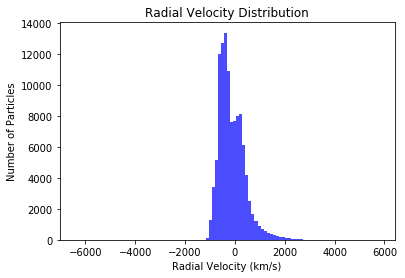

Average outflow divergence at snap=25, galaxy id=39895, halo id=289: [ -44.16356858  -40.12369497 -113.59378337 ...  694.77934628 1295.52747752
  770.91108183]


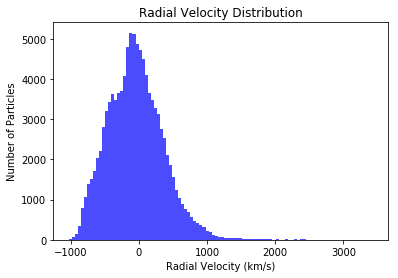

Average outflow divergence at snap=33, galaxy id=107233, halo id=516: [ -44.16356858  -40.12369497 -113.59378337 ...  694.77934628 1295.52747752
  770.91108183]


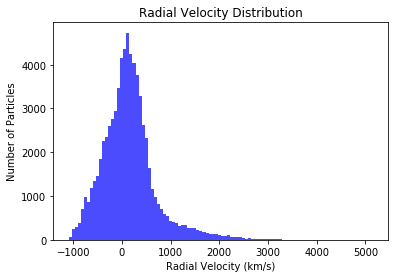

Average outflow divergence at snap=40, galaxy id=175977, halo id=784: [ -44.16356858  -40.12369497 -113.59378337 ...  694.77934628 1295.52747752
  770.91108183]


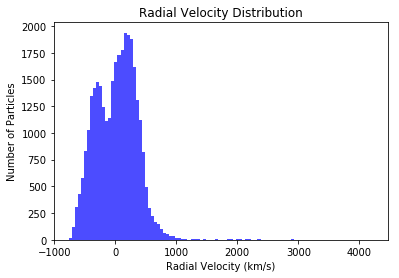

Average outflow divergence at snap=50, galaxy id=266546, halo id=1091: [ -44.16356858  -40.12369497 -113.59378337 ...  694.77934628 1295.52747752
  770.91108183]


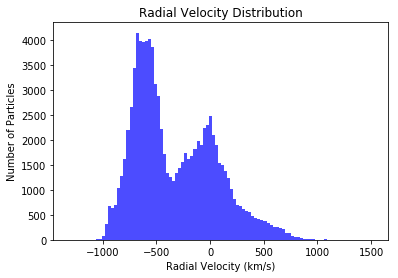

Average outflow divergence at snap=59, galaxy id=274520, halo id=680: [ -44.16356858  -40.12369497 -113.59378337 ...  694.77934628 1295.52747752
  770.91108183]


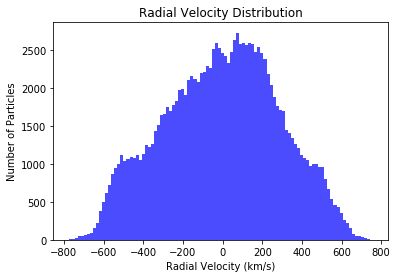

Average outflow divergence at snap=67, galaxy id=296833, halo id=574: [ -44.16356858  -40.12369497 -113.59378337 ...  694.77934628 1295.52747752
  770.91108183]


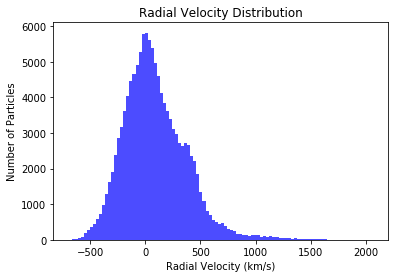

Average outflow divergence at snap=72, galaxy id=316818, halo id=570: [ -44.16356858  -40.12369497 -113.59378337 ...  694.77934628 1295.52747752
  770.91108183]


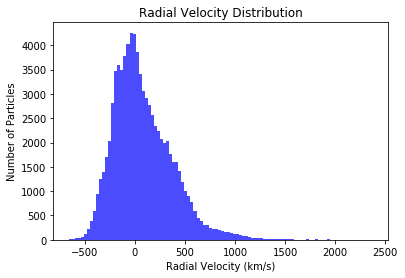

Average outflow divergence at snap=78, galaxy id=337032, halo id=564: [ -44.16356858  -40.12369497 -113.59378337 ...  694.77934628 1295.52747752
  770.91108183]


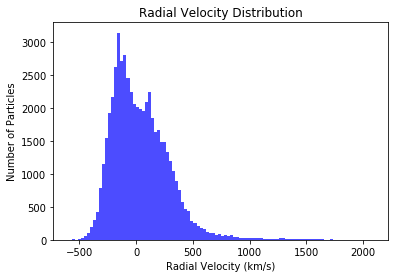

Average outflow divergence at snap=84, galaxy id=365040, halo id=593: [ -44.16356858  -40.12369497 -113.59378337 ...  694.77934628 1295.52747752
  770.91108183]


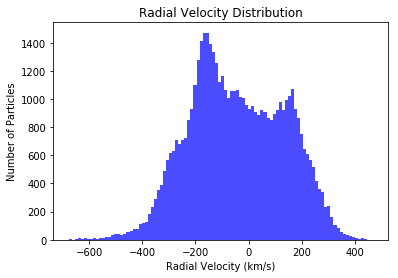

Average outflow divergence at snap=91, galaxy id=387977, halo id=593: [ -44.16356858  -40.12369497 -113.59378337 ...  694.77934628 1295.52747752
  770.91108183]


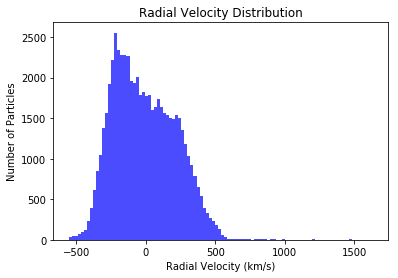

Average outflow divergence at snap=99, galaxy id=408764, halo id=572: [ -44.16356858  -40.12369497 -113.59378337 ...  694.77934628 1295.52747752
  770.91108183]


In [50]:
def visualize_gas_flow(part_data, agn_position):
    # Calculate the position of the particles relative to the AGN
    relative_pos = part_data['Coordinates'] - agn_position
    distances = np.linalg.norm(relative_pos, axis=1)
    
    # Calculate the radial velocities
    radial_velocities = np.sum(relative_pos * part_data['Velocities'], axis=1) / distances
    
    # Plot radial velocity distribution
    plt.hist(radial_velocities, bins=100, color='blue', alpha=0.7)
    plt.xlabel('Radial Velocity (km/s)')
    plt.ylabel('Number of Particles')
    plt.title('Radial Velocity Distribution')
    plt.show()

# Loop over each subhalo ID and their snapshot
for snap, i in zip(snapshots, ids):
    # Get the main halo ID (Group Number) for the subhalo
    main_halo_id = il.groupcat.loadSingle(basePath, snap, subhaloID=i)['SubhaloGrNr']
    
    # Load the properties of the main halo
    main_halo_properties = il.groupcat.loadSingle(basePath, snap, haloID=main_halo_id)
    
    # Get the position of the main halo
    agn_position = main_halo_properties['GroupPos']
    
    # Load the particle data for the halo
    part_data = il.snapshot.loadHalo(basePath, snap, main_halo_id, partType='gas', fields=['Coordinates', 'Velocities'])
    
    # Visualize the gas flow
    visualize_gas_flow(part_data, agn_position)

    # Print the average outflow divergence
    print(f'Average outflow divergence at snap={snap}, galaxy id={i}, halo id={main_halo_id}: {radial_velocities}')

In [51]:
def calculate_radial_velocity(positions, velocities, agn_position):
    # Calculate the relative positions and distances of the particles
    relative_positions = positions - agn_position
    distances = np.linalg.norm(relative_positions, axis=1)

    # Calculate the radial velocities
    radial_velocities = np.sum(relative_positions * velocities, axis=1) / distances

    return radial_velocities

# Define lists to store the results
average_radial_velocity_list = []


# Loop over each subhalo ID and there snapshot
for snap, i in zip(snapshots, ids):
    # Get the main halo ID (Group Number) for the subhalo
    main_halo_id = il.groupcat.loadSingle(basePath, snap, subhaloID=i)['SubhaloGrNr']
    
    # Load the properties of the main halo
    main_halo_properties = il.groupcat.loadSingle(basePath, snap, haloID=main_halo_id)
    
    # Get the position of the main halo
    agn_position = main_halo_properties['GroupPos']
    
    # Load the particle data for the halo
    part_data = il.snapshot.loadHalo(basePath, snap, main_halo_id, partType='gas', fields=['Coordinates', 'Velocities'])

    # Calculate the radial velocities
    radial_velocities = calculate_radial_velocity(part_data['Coordinates'], part_data['Velocities'], agn_position)

    # Calculate the average radial velocity
    average_radial_velocity = np.mean(radial_velocities)
    
    average_radial_velocity_list.append(average_radial_velocity)

    # Print the average radial velocity
    print(f'Average radial velocity at snap={snap}, id={i}, halo id={main_halo_id}: {average_radial_velocity}')
    
df = pd.read_csv('TNG_408764.csv')
df['Average radial velocity'] = average_radial_velocity_list
df.to_csv('TNG_408764.csv', index=False)

Average radial velocity at snap=25, id=39895, halo id=289: -126.64680563018314
Average radial velocity at snap=33, id=107233, halo id=516: -45.59284199566698
Average radial velocity at snap=40, id=175977, halo id=784: 150.65979156884126
Average radial velocity at snap=50, id=266546, halo id=1091: 20.529851192549827
Average radial velocity at snap=59, id=274520, halo id=680: -328.5679758650641
Average radial velocity at snap=67, id=296833, halo id=574: -3.2081636420329067
Average radial velocity at snap=72, id=316818, halo id=570: 89.30344839569781
Average radial velocity at snap=78, id=337032, halo id=564: 83.49756227210514
Average radial velocity at snap=84, id=365040, halo id=593: 41.563372046254834
Average radial velocity at snap=91, id=387977, halo id=593: -42.98086071173714
Average radial velocity at snap=99, id=408764, halo id=572: -8.270620988864993


In [43]:
# List to store BH masses
bhmass_values = []

fields = 'BH_Mass'

# Loop over each subhalo ID and there snapshot
for snap, id in zip(snapshots, ids):
    # Load the BH data for this snapshot and subhalo ID.
    bh_data = il.snapshot.loadSubhalo(basePath, snap, id, "BH", fields=fields)

    # Calculate the BH mass.
    if isinstance(bh_data, np.ndarray) and bh_data.size > 0:  # Check if bh_data is a non-empty array.
        bh_mass = bh_data[0] * ((1e10) / h) #covert the bh mases
    elif isinstance(bh_data, dict) and 'BH_Mass' in bh_data and len(bh_data['BH_Mass']) > 0:  # Check if there is BH data.
        bh_mass = bh_data['BH_Mass'][0] * ((1e10) / h)
    else:  # If no BH data, set the BH mass to zero.
        bh_mass = 0.0
        
    #covert the bh masess to log10 
    bh_mass = np.log10(bh_mass)

    # Append the BH mass to the list.
    bhmass_values.append(bh_mass)
    
    print(f'Blackhole Masses at snap={snap}, id={id}: {bh_mass}')
    
df = pd.read_csv('TNG_408764.csv')
df['Blackhole Masses'] = bhmass_values
df.to_csv('TNG_408764.csv', index=False)

Blackhole Masses at snap=25, id=39895: 8.515736000902672
Blackhole Masses at snap=33, id=107233: 8.546695276970196
Blackhole Masses at snap=40, id=175977: 8.553063723774862
Blackhole Masses at snap=50, id=266546: 8.554340524970335
Blackhole Masses at snap=59, id=274520: 8.55455772891537
Blackhole Masses at snap=67, id=296833: 8.554719162320612
Blackhole Masses at snap=72, id=316818: 8.698481219875264
Blackhole Masses at snap=78, id=337032: 8.698838582080853
Blackhole Masses at snap=84, id=365040: 8.6990046391601
Blackhole Masses at snap=91, id=387977: 8.699020257488298
Blackhole Masses at snap=99, id=408764: 8.69908005091109


In [52]:
# List to store BHmdot
bhmdot_values = []

fields = 'BH_Mdot'

# Loop over each subhalo ID and there snapshot
for snap, id in zip(snapshots, ids):
    # Load the BH data for this snapshot and subhalo ID.
    bh_data = il.snapshot.loadSubhalo(basePath, snap, id, "BH", fields=fields)

    # Calculate the BHmdot.
    if isinstance(bh_data, np.ndarray) and bh_data.size > 0:  # Check if bh_data is a non-empty array.
        bh_dot = bh_data[0] * ((1e10 * Msun) / (h * Gyr_to_s)) #covert the BHmdot
    elif isinstance(bh_data, dict) and 'BH_Mdot' in bh_data and len(bh_data['BH_Mdot']) > 0:  # Check if there is BH data.
        bh_dot = bh_data['BH_Mdot'][0] * ((1e10 * Msun) / (h * Gyr_to_s))
    else:  # If no BH data, set the BHmdot to zero.
        bh_dot = 0.0
        
    #covert the BHmdot to log10 
    bh_dot = np.log10(bh_dot)

    # Append the BHmdot to the list.
    bhmdot_values.append(bh_dot)
    
    
# Print the BHmdot
print("Bhmdot:")
print(bhmdot_values) 

df = pd.read_csv('TNG_408764.csv')
df['Bhmdot'] = bhmdot_values
df.to_csv('TNG_408764.csv', index=False)

Bhmdot:
[24.05540587821552, 22.901954233313656, 23.431165765951718, 22.411176314170508, 21.30058035867288, 21.085171325651523, 22.499468811602892, 21.94963279628191, 21.771163950407, 21.362796320015523, 21.435409673788673]


In [45]:
# List to store Star formation rate
sfr_values = []

# Loop over each subhalo ID and there snapshot
for snap, i in zip(snapshots, ids):
    #load the galaxies
    sfr = il.groupcat.loadSingle(basePath, snap, subhaloID=i)
    #extract the value of the sfr
    sfr_value = sfr['SubhaloSFRinHalfRad']
    sfr_values.append(sfr_value)
    print(f'Subhalo SFR at snap={snap}, id={i}: {sfr_value}')

df = pd.read_csv('TNG_408764.csv')
df['SFR'] = sfr_values
df.to_csv('TNG_408764.csv', index=False)

Subhalo SFR at snap=25, id=39895: 0.0
Subhalo SFR at snap=33, id=107233: 0.0
Subhalo SFR at snap=40, id=175977: 0.03534984961152077
Subhalo SFR at snap=50, id=266546: 0.0
Subhalo SFR at snap=59, id=274520: 0.0
Subhalo SFR at snap=67, id=296833: 0.0
Subhalo SFR at snap=72, id=316818: 0.0005703930510208011
Subhalo SFR at snap=78, id=337032: 0.0
Subhalo SFR at snap=84, id=365040: 0.0
Subhalo SFR at snap=91, id=387977: 0.0
Subhalo SFR at snap=99, id=408764: 0.0


In [46]:
# Create empty list to store of fraction χ of the Eddington accretion rate values
χ_rate_list = []

fields=["BH_Mass", "BH_Mdot", "BH_MdotEddington"]

# Loop over each subhalo ID and there snapshot
for snapshot, id in zip(snapshots, ids):
    # Load black hole properties for specific subhalo
    blackholes = il.snapshot.loadSubhalo(basePath, snapshot, id, "BH", fields=fields)
    
    # Calculate the BHdot.
    if isinstance(blackholes, np.ndarray) and blackholes.size > 0 and blackholes['BH_Mdot'][0] != 0:  
        bhdot = blackholes['BH_Mdot'][0]
    elif isinstance(blackholes, dict) and 'BH_Mdot' in blackholes and len(blackholes['BH_Mdot']) > 0 and blackholes['BH_Mdot'][0] != 0: 
        bhdot = blackholes['BH_Mdot'][0]
    else:  
        bhdot = np.nan  # Set to np.nan so that the resulting χ_rate will be np.nan.
        
    # Calculate the BH eddington.
    if isinstance(blackholes, np.ndarray) and blackholes.size > 0 and blackholes['BH_MdotEddington'][0] != 0:  
        bhedd = blackholes['BH_MdotEddington'][0]
    elif isinstance(blackholes, dict) and 'BH_MdotEddington' in blackholes and len(blackholes['BH_MdotEddington']) > 0 and blackholes['BH_MdotEddington'][0] != 0:  
        bhedd = blackholes['BH_MdotEddington'][0]
    else:  
        bhedd = np.nan  # Set to np.nan so that the resulting χ_rate will be np.nan.

        
    # Calculate χ_rate
    χ_rate = (bhdot / bhedd)

    
    # Append χ_rate to the list
    χ_rate_list.append(χ_rate)


# Print fraction χ values
print("χ values:")
print(χ_rate_list)

df = pd.read_csv('TNG_408764.csv')
df['χ'] = χ_rate_list
df.to_csv('TNG_408764.csv', index=False)

χ values:
[0.003431562966919867, 0.00022442694108925474, 0.0007480292078903628, 7.122817803564398e-05, 5.518721906192186e-06, 3.3594489212024234e-06, 6.26330462282858e-05, 1.764453096369501e-05, 1.1694326855779381e-05, 4.566588758366862e-06, 5.396913895995949e-06]


In [47]:
# Create empty list to store the bolometric luminosity values
L_list = []

fields=["BH_Mass", "BH_Mdot"]

# Loop over each subhalo ID and there snapshot
for snapshot, id in zip(snapshots, ids):
    # Load black hole properties for specific subhalo
    blackholes = il.snapshot.loadSubhalo(basePath, snapshot, id, "BH", fields=fields)
    
    # Calculate the BHdot.
    if isinstance(blackholes, np.ndarray) and blackholes.size > 0 and blackholes['BH_Mdot'][0] != 0:  
        bhdot = blackholes['BH_Mdot'][0] * ((1e10 * Msun) / (h * Gyr_to_s))
    elif isinstance(blackholes, dict) and 'BH_Mdot' in blackholes and len(blackholes['BH_Mdot']) > 0 and blackholes['BH_Mdot'][0] != 0: 
        bhdot = blackholes['BH_Mdot'][0] * ((1e10 * Msun) / (h * Gyr_to_s))
    else:  
        bhdot = np.nan  # Set to np.nan so that the resulting L_bol will be np.nan.

    # Calculate L_bol
    L_bol = e_r * bhdot * c**2

    
    # Append bolometric luminosity to the list
    L_list.append(np.log10(L_bol))


# Print bolometric luminosity values
print("Bol Luminosity values:")
print(L_list)

df = pd.read_csv('TNG_408764.csv')
df['L_bol'] = L_list
df.to_csv('TNG_408764.csv', index=False)

Bol Luminosity values:
[44.31007727973536, 43.156625634833496, 43.685837167471554, 42.66584771569034, 41.55525176019272, 41.33984272717136, 42.75414021312273, 42.20430419780175, 42.02583535192684, 41.617467721535355, 41.690081075308505]


In [48]:
# Create empty list to store the Eddington luminosity values
L_edd_list = []

e_r = 0.2

fields=["BH_Mass", "BH_MdotEddington"]

# Loop over each subhalo ID and there snapshot
for snapshot, id in zip(snapshots, ids):
    # Load black hole properties for specific subhalo
    blackholes = il.snapshot.loadSubhalo(basePath, snapshot, id, "BH", fields=fields)
    
    # Calculate the BH eddington.
    if isinstance(blackholes, np.ndarray) and blackholes.size > 0 and blackholes['BH_MdotEddington'][0] != 0:  
        bhedd = blackholes['BH_MdotEddington'][0] * ((1e10 * Msun) / (h * Gyr_to_s))
    elif isinstance(blackholes, dict) and 'BH_MdotEddington' in blackholes and len(blackholes['BH_MdotEddington']) > 0 and blackholes['BH_MdotEddington'][0] != 0: 
        bhedd = blackholes['BH_MdotEddington'][0] * ((1e10 * Msun) / (h * Gyr_to_s))
    else:  
        bhedd = np.nan  # Set to np.nan so that the resulting L_edd will be np.nan.


    # Calculate L_edd
    L_edd = e_r * bhedd * c**2

    
    # Append Eddington luminosity to the list
    L_edd_list.append(np.log10(L_edd))


# Print Eddington luminosity values
print("Edd Luminosity values:")
print(L_edd_list)

df = pd.read_csv('TNG_408764.csv')
df['L_edd'] = L_edd_list
df.to_csv('TNG_408764.csv', index=False)

Edd Luminosity values:
[46.77458530741791, 46.80555064470885, 46.81191861161516, 46.81319588013682, 46.81341325010084, 46.81357468493315, 46.95733667850968, 46.957694079599186, 46.95786012374953, 46.95787581831759, 46.95793558605414]


In [49]:
# Create empty list to store the feedback energy of the AGN values
E_feed_list = []


Msun = 1.989e33 # in grams
Gyr_to_s = 3.15576e16 # in seconds
h = 0.6774

fields=["BH_Mass", "BH_Mdot"]

# Loop over each subhalo ID and there snapshot
for snapshot, id in zip(snapshots, ids):
    # Load black hole properties for specific subhalo
    blackholes = il.snapshot.loadSubhalo(basePath, snapshot, id, "BH", fields=fields)
    
    # Calculate the BHdot.
    if isinstance(blackholes, np.ndarray) and blackholes.size > 0 and blackholes['BH_Mdot'][0] != 0:  
        bhdot = blackholes['BH_Mdot'][0] * ((1e10 * Msun) / (h * Gyr_to_s))
    elif isinstance(blackholes, dict) and 'BH_Mdot' in blackholes and len(blackholes['BH_Mdot']) > 0 and blackholes['BH_Mdot'][0] != 0: 
        bhdot = blackholes['BH_Mdot'][0] * ((1e10 * Msun) / (h * Gyr_to_s))
    else:  
        bhdot = np.nan  # Set to np.nan so that the resulting feedback energy will be np.nan.

        
    # Calculate feedback energy
    E_feed = e_fm * bhdot * c**2

    
    # Append feedback energy to the list
    E_feed_list.append(np.log10(E_feed))


# Print feedback energy values
print("E_feed values:")
print(E_feed_list)

df = pd.read_csv('TNG_408764.csv')
df['E_feed'] = E_feed_list
df.to_csv('TNG_408764.csv', index=False)

E_feed values:
[44.31007727973536, 43.156625634833496, 43.685837167471554, 42.66584771569034, 41.55525176019272, 41.33984272717136, 42.75414021312273, 42.20430419780175, 42.02583535192684, 41.617467721535355, 41.690081075308505]


In [50]:
# Prepare empty lists to store the logarithm values
QM_values = []
RM_values = []

# Loop over each subhalo ID and their snapshot
for snapshot, id in zip(snapshots, ids):
    # Load necessary fields
    fields = ['BH_CumEgyInjection_QM', 'BH_CumEgyInjection_RM']
    data = il.snapshot.loadSubhalo(basePath, snapshot, id, 'BH', fields=fields)
    
    # Convert units
    BH_CumEgyInjection_QM_phys = np.sqrt(data['BH_CumEgyInjection_QM'] * 1e10 / 0.7 / (0.978 / 0.7)**2)
    BH_CumEgyInjection_RM_phys = np.sqrt(data['BH_CumEgyInjection_RM'] * 1e10 / 0.7 / (0.978 / 0.7)**2)

    # Calculate the logarithm and replace -inf with 0
    QM_log = np.log10(BH_CumEgyInjection_QM_phys)
    RM_log = np.log10(BH_CumEgyInjection_RM_phys)
    
    QM_log[np.isneginf(QM_log)] = 0
    RM_log[np.isneginf(RM_log)] = 0

    QM_values.append(QM_log[0])  # Only store the first (and only) value in the array
    RM_values.append(RM_log[0])  # Only store the first (and only) value in the array

    print(f'Logarithmic QM and RM at snap={snapshot}, id={id}: {QM_log[0]}, {RM_log[0]}')
    
df = pd.read_csv('TNG_408764.csv')
df['Log_EQM'] = QM_values
df['Log_ERM'] = RM_values
df.to_csv('TNG_408764.csv', index=False)

Logarithmic QM and RM at snap=25, id=39895: 8.778714654549962, 7.779421527229899
Logarithmic QM and RM at snap=33, id=107233: 8.79088398554675, 8.296281379254825
Logarithmic QM and RM at snap=40, id=175977: 8.79220307305905, 8.391452000385659
Logarithmic QM and RM at snap=50, id=266546: 8.79220307305905, 8.429749306578026
Logarithmic QM and RM at snap=59, id=274520: 8.79220307305905, 8.43550975369787
Logarithmic QM and RM at snap=67, id=296833: 8.79220307305905, 8.43975434638908
Logarithmic QM and RM at snap=72, id=316818: 8.865642014988262, 8.464314151876332
Logarithmic QM and RM at snap=78, id=337032: 8.865642014988262, 8.475691883383329
Logarithmic QM and RM at snap=84, id=365040: 8.865642014988262, 8.48033551794586
Logarithmic QM and RM at snap=91, id=387977: 8.865642014988262, 8.480439673214265
Logarithmic QM and RM at snap=99, id=408764: 8.865642014988262, 8.481355591382345


In [24]:
#lets view the compilation of the file 
df = pd.read_csv('TNG_408764.csv')
print(df.head())

   Redshift (z)  Average divergence  Average radial velocity  \
0           3.0           -3.053387               -64.992105   
1           2.0            0.659925              -124.967875   
2           1.5            1.260953               -30.659360   
3           1.0           -1.428051               -52.205839   
4           0.7           -2.432134              -274.048032   

   Blackhole Masses     Bhmdot      SFR         χ      L_bol      L_edd  \
0          8.515736  24.055406  0.00000  0.003432  44.310077  46.774585   
1          8.546695  22.901954  0.00000  0.000224  43.156626  46.805551   
2          8.553064  23.431166  0.03535  0.000748  43.685837  46.811919   
3          8.554341  22.411176  0.00000  0.000071  42.665848  46.813196   
4          8.554558  21.300580  0.00000  0.000006  41.555252  46.813413   

      E_feed   Log_EQM   Log_ERM  Average divergence of Halo  
0  44.310077  8.778715  7.779422                   -0.837105  
1  43.156626  8.790884  8.296281      